In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import periodogram, welch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

/home/luo/miniconda3/envs/comp0233/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
# ============ Data Loading Module ============

def load_mat_data(filename='data/hd174966_miarma_processed.mat'):
    """
    Load MATLAB .mat format MIARMA processed data
    
    Parameters:
    -----------
    filename : str
        Path to MAT file in data directory
    
    Returns:
    --------
    tuple : (time, flux) or (None, None) if failed
    """
    try:
        mat_data = loadmat(filename)
        time = mat_data['time'].flatten()
        flux = mat_data['flux_relative'].flatten()
        print(f"Successfully loaded {filename}")
        return time, flux
    except Exception as e:
        print(f"Failed to load MAT file: {e}")
        return None, None


# ============ Data Quality Assessment Module ============

def calculate_sampling_statistics(time):
    """
    Calculate sampling interval statistics
    
    Parameters:
    -----------
    time : array_like
        Time array in Julian days
    
    Returns:
    --------
    dict : Dictionary containing sampling statistics
    """
    time_diff = np.diff(time)
    dt_median = np.median(time_diff)
    dt_std = np.std(time_diff)
    dt_seconds = dt_median * 86400  # Convert to seconds
    
    stats = {
        'median_interval_sec': dt_seconds,
        'std_interval_sec': dt_std * 86400,
        'coefficient_variation': dt_std / dt_median * 100,
        'min_interval_sec': np.min(time_diff) * 86400,
        'max_interval_sec': np.max(time_diff) * 86400,
        'duplicate_times': np.sum(time_diff == 0),
        'negative_intervals': np.sum(time_diff < 0),
        'median_interval_days': dt_median,
        'sampling_frequency': 1.0 / dt_median
    }
    
    return stats


def calculate_time_series_quality(time, flux):
    """
    Calculate time series quality metrics
    
    Parameters:
    -----------
    time : array_like
        Time array in Julian days
    flux : array_like
        Flux array (relative)
    
    Returns:
    --------
    dict : Dictionary containing quality metrics
    """
    observation_length = time.max() - time.min()
    data_coverage = len(time) * np.median(np.diff(time)) / observation_length * 100
    
    flux_detrended = flux - np.mean(flux)
    relative_amplitude = np.std(flux_detrended) / np.abs(np.mean(flux)) * 100
    
    quality = {
        'observation_length_days': observation_length,
        'data_coverage_percent': data_coverage,
        'total_points': len(time),
        'relative_amplitude_percent': relative_amplitude,
        'flux_mean': np.mean(flux),
        'flux_std': np.std(flux_detrended)
    }
    
    return quality


def calculate_frequency_content(flux, sampling_frequency):
    """
    Analyze frequency content using Welch's method
    
    Parameters:
    -----------
    flux : array_like
        Flux time series
    sampling_frequency : float
        Sampling frequency in d^-1
    
    Returns:
    --------
    dict : Dictionary containing frequency analysis results
    """
    # Calculate power spectrum using Welch's method
    frequencies, power = welch(flux, fs=sampling_frequency, nperseg=len(flux)//4, 
                              scaling='density', detrend='linear')
    
    # Find significant peaks
    power_smooth = gaussian_filter(power, sigma=2)
    peak_threshold = np.mean(power_smooth) + 3 * np.std(power_smooth)
    significant_peaks = frequencies[power_smooth > peak_threshold]
    
    # Analyze different frequency ranges
    delta_scuti_range = (frequencies >= 3) & (frequencies <= 80)
    low_freq_range = (frequencies >= 0.1) & (frequencies <= 3)
    high_freq_range = (frequencies >= 80) & (frequencies <= frequencies.max()/2)
    
    peaks_in_delta_scuti = significant_peaks[(significant_peaks >= 3) & (significant_peaks <= 80)]
    
    freq_analysis = {
        'frequency_resolution': frequencies[1] - frequencies[0],
        'nyquist_frequency': frequencies.max(),
        'significant_peaks_total': len(significant_peaks),
        'peaks_in_delta_scuti_range': len(peaks_in_delta_scuti),
        'low_freq_power': np.mean(power[low_freq_range]),
        'delta_scuti_power': np.mean(power[delta_scuti_range]),
        'high_freq_power': np.mean(power[high_freq_range]),
        'snr_estimate': np.mean(power[delta_scuti_range]) / np.mean(power[high_freq_range])
    }
    
    return freq_analysis, frequencies, power


def assess_sampling_regularity(sampling_stats):
    """
    Assess quality of MIARMA processing based on sampling regularity
    
    Parameters:
    -----------
    sampling_stats : dict
        Output from calculate_sampling_statistics()
    
    Returns:
    --------
    dict : Assessment results
    """
    regularity_index = sampling_stats['std_interval_sec'] / sampling_stats['median_interval_sec']
    
    if regularity_index < 1e-6:
        quality_level = "Excellent"
        status = "Very regular sampling, MIARMA processing successful"
    elif regularity_index < 1e-3:
        quality_level = "Good"
        status = "Mostly regular sampling, minor irregularities present"
    else:
        quality_level = "Poor"
        status = "Irregular sampling, may need reprocessing"
    
    assessment = {
        'regularity_index': regularity_index,
        'quality_level': quality_level,
        'status_message': status
    }
    
    return assessment


def check_sscwt_suitability(time, sampling_stats, freq_analysis):
    """
    Check if data is suitable for SSCWT analysis
    
    Parameters:
    -----------
    time : array_like
        Time array
    sampling_stats : dict
        Sampling statistics
    freq_analysis : dict
        Frequency analysis results
    
    Returns:
    --------
    dict : Suitability assessment
    """
    observation_length = time.max() - time.min()
    min_detectable_freq = 1.0 / observation_length
    nyquist_freq = freq_analysis['nyquist_frequency']
    
    # Check target frequencies from Ramon-Ballesta et al. (2022)
    target_frequencies = [5.51, 6.3]
    detectable_targets = [freq for freq in target_frequencies if freq < nyquist_freq]
    
    suitability = {
        'observation_length_days': observation_length,
        'min_detectable_frequency': min_detectable_freq,
        'nyquist_frequency': nyquist_freq,
        'covers_delta_scuti_range': nyquist_freq > 80,
        'target_frequencies_detectable': len(detectable_targets),
        'total_target_frequencies': len(target_frequencies),
        'suitable_for_sscwt': nyquist_freq > 80 and observation_length > 10
    }
    
    return suitability


def comprehensive_data_quality_assessment():
    """
    Perform comprehensive data quality assessment for HD 174966
    
    Returns:
    --------
    dict : Complete quality assessment results
    """
    print("=== HD 174966 Comprehensive Data Quality Assessment ===\n")
    
    # Load data
    time, flux = load_mat_data()
    if time is None:
        return None
    
    # Calculate relative time
    time_rel = time - time[0]
    
    # 1. Sampling statistics
    print("1. Sampling Quality Assessment")
    print("-" * 40)
    sampling_stats = calculate_sampling_statistics(time)
    
    print(f"Sampling interval statistics:")
    print(f"  Median: {sampling_stats['median_interval_sec']:.2f} seconds")
    print(f"  Standard deviation: {sampling_stats['std_interval_sec']:.4f} seconds")
    print(f"  Coefficient of variation: {sampling_stats['coefficient_variation']:.6f}%")
    print(f"  Min interval: {sampling_stats['min_interval_sec']:.2f} seconds")
    print(f"  Max interval: {sampling_stats['max_interval_sec']:.2f} seconds")
    print(f"  Duplicate time points: {sampling_stats['duplicate_times']}")
    print(f"  Negative intervals: {sampling_stats['negative_intervals']}")
    
    # 2. MIARMA processing quality
    print(f"\n2. MIARMA Processing Quality")
    print("-" * 40)
    regularity_assessment = assess_sampling_regularity(sampling_stats)
    print(f"Sampling regularity index: {regularity_assessment['regularity_index']:.2e}")
    print(f"Quality level: {regularity_assessment['quality_level']}")
    print(f"Status: {regularity_assessment['status_message']}")
    
    # 3. Time series quality
    print(f"\n3. Time Series Quality")
    print("-" * 40)
    ts_quality = calculate_time_series_quality(time, flux)
    print(f"Observation length: {ts_quality['observation_length_days']:.2f} days")
    print(f"Data coverage: {ts_quality['data_coverage_percent']:.2f}%")
    print(f"Total data points: {ts_quality['total_points']}")
    print(f"Relative amplitude: {ts_quality['relative_amplitude_percent']:.4f}%")
    print(f"Typical δ Scuti amplitude: 0.001-0.1%")
    
    # 4. Frequency content analysis
    print(f"\n4. Frequency Content Analysis")
    print("-" * 40)
    freq_analysis, frequencies, power = calculate_frequency_content(flux, sampling_stats['sampling_frequency'])
    
    print(f"Frequency analysis:")
    print(f"  Frequency resolution: {freq_analysis['frequency_resolution']:.6f} d⁻¹")
    print(f"  Nyquist frequency: {freq_analysis['nyquist_frequency']:.2f} d⁻¹")
    print(f"  Significant peaks total: {freq_analysis['significant_peaks_total']}")
    print(f"  Peaks in δ Scuti range: {freq_analysis['peaks_in_delta_scuti_range']}")
    print(f"  García et al. 2013 reported: 185 frequencies")
    print(f"  Signal-to-noise ratio: {freq_analysis['snr_estimate']:.2f}")
    
    # 5. SSCWT suitability
    print(f"\n5. SSCWT Suitability Assessment")
    print("-" * 40)
    sscwt_assessment = check_sscwt_suitability(time, sampling_stats, freq_analysis)
    
    print(f"Time-frequency analysis parameters:")
    print(f"  Observation length: {sscwt_assessment['observation_length_days']:.2f} days")
    print(f"  Min detectable frequency: {sscwt_assessment['min_detectable_frequency']:.4f} d⁻¹")
    print(f"  Nyquist frequency: {sscwt_assessment['nyquist_frequency']:.2f} d⁻¹")
    print(f"  Covers delta Scuti range: {sscwt_assessment['covers_delta_scuti_range']}")
    print(f"  Target frequencies detectable: {sscwt_assessment['target_frequencies_detectable']}/{sscwt_assessment['total_target_frequencies']}")
    print(f"  Suitable for SSCWT: {sscwt_assessment['suitable_for_sscwt']}")
    
    # Compile all results
    complete_assessment = {
        'sampling_stats': sampling_stats,
        'regularity_assessment': regularity_assessment,
        'time_series_quality': ts_quality,
        'frequency_analysis': freq_analysis,
        'sscwt_suitability': sscwt_assessment,
        'data_source': 'MAT file'
    }
    
    return complete_assessment, time, flux, time_rel


def plot_quality_assessment_figures():
    """
    Generate quality assessment figures for publication
    
    Returns:
    --------
    matplotlib.figure.Figure : Figure object
    """
    # Load data
    time, flux = load_mat_data()
    if time is None:
        print("Cannot generate figures: data loading failed")
        return None
    
    time_rel = time - time[0]
    sampling_stats = calculate_sampling_statistics(time)
    freq_analysis, frequencies, power = calculate_frequency_content(flux, sampling_stats['sampling_frequency'])
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Light curve
    axes[0,0].plot(time_rel, flux, 'b-', alpha=0.7, linewidth=0.5)
    axes[0,0].set_xlabel('Time (days)')
    axes[0,0].set_ylabel('Relative Flux')
    axes[0,0].set_title('HD 174966 Light Curve (MIARMA Processed)')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Sampling interval distribution
    time_diff = np.diff(time) * 86400  # Convert to seconds
    axes[0,1].hist(time_diff, bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(np.median(time_diff), color='red', linestyle='--', 
                     label=f'Median: {np.median(time_diff):.2f} s')
    axes[0,1].set_xlabel('Sampling Interval (seconds)')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Sampling Interval Distribution')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Full power spectrum
    axes[1,0].loglog(frequencies, power, 'b-', alpha=0.8)
    axes[1,0].axvline(3, color='red', linestyle='--', alpha=0.7, label='δ Sct range')
    axes[1,0].axvline(80, color='red', linestyle='--', alpha=0.7)
    axes[1,0].set_xlabel('Frequency (d⁻¹)')
    axes[1,0].set_ylabel('Power Spectral Density')
    axes[1,0].set_title('Power Spectrum')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. δ Scuti frequency range detail
    delta_scuti_mask = (frequencies >= 3) & (frequencies <= 80)
    axes[1,1].semilogy(frequencies[delta_scuti_mask], power[delta_scuti_mask], 'b-')
    axes[1,1].set_xlabel('Frequency (d⁻¹)')
    axes[1,1].set_ylabel('Power Spectral Density')
    axes[1,1].set_title('δ Scuti Frequency Range (3-80 d⁻¹)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/hd174966_quality_assessment.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig



Successfully loaded data/hd174966_miarma_processed.mat
=== HD 174966 Comprehensive Data Quality Assessment ===

Successfully loaded data/hd174966_miarma_processed.mat
1. Sampling Quality Assessment
----------------------------------------
Sampling interval statistics:
  Median: 32.00 seconds
  Standard deviation: 0.0000 seconds
  Coefficient of variation: 0.000000%
  Min interval: 32.00 seconds
  Max interval: 32.00 seconds
  Duplicate time points: 0
  Negative intervals: 0

2. MIARMA Processing Quality
----------------------------------------
Sampling regularity index: 7.68e-10
Quality level: Excellent
Status: Very regular sampling, MIARMA processing successful

3. Time Series Quality
----------------------------------------
Observation length: 27.27 days
Data coverage: 100.00%
Total data points: 73617
Relative amplitude: 194079053434296.8125%
Typical δ Scuti amplitude: 0.001-0.1%

4. Frequency Content Analysis
----------------------------------------
Frequency analysis:
  Frequency r

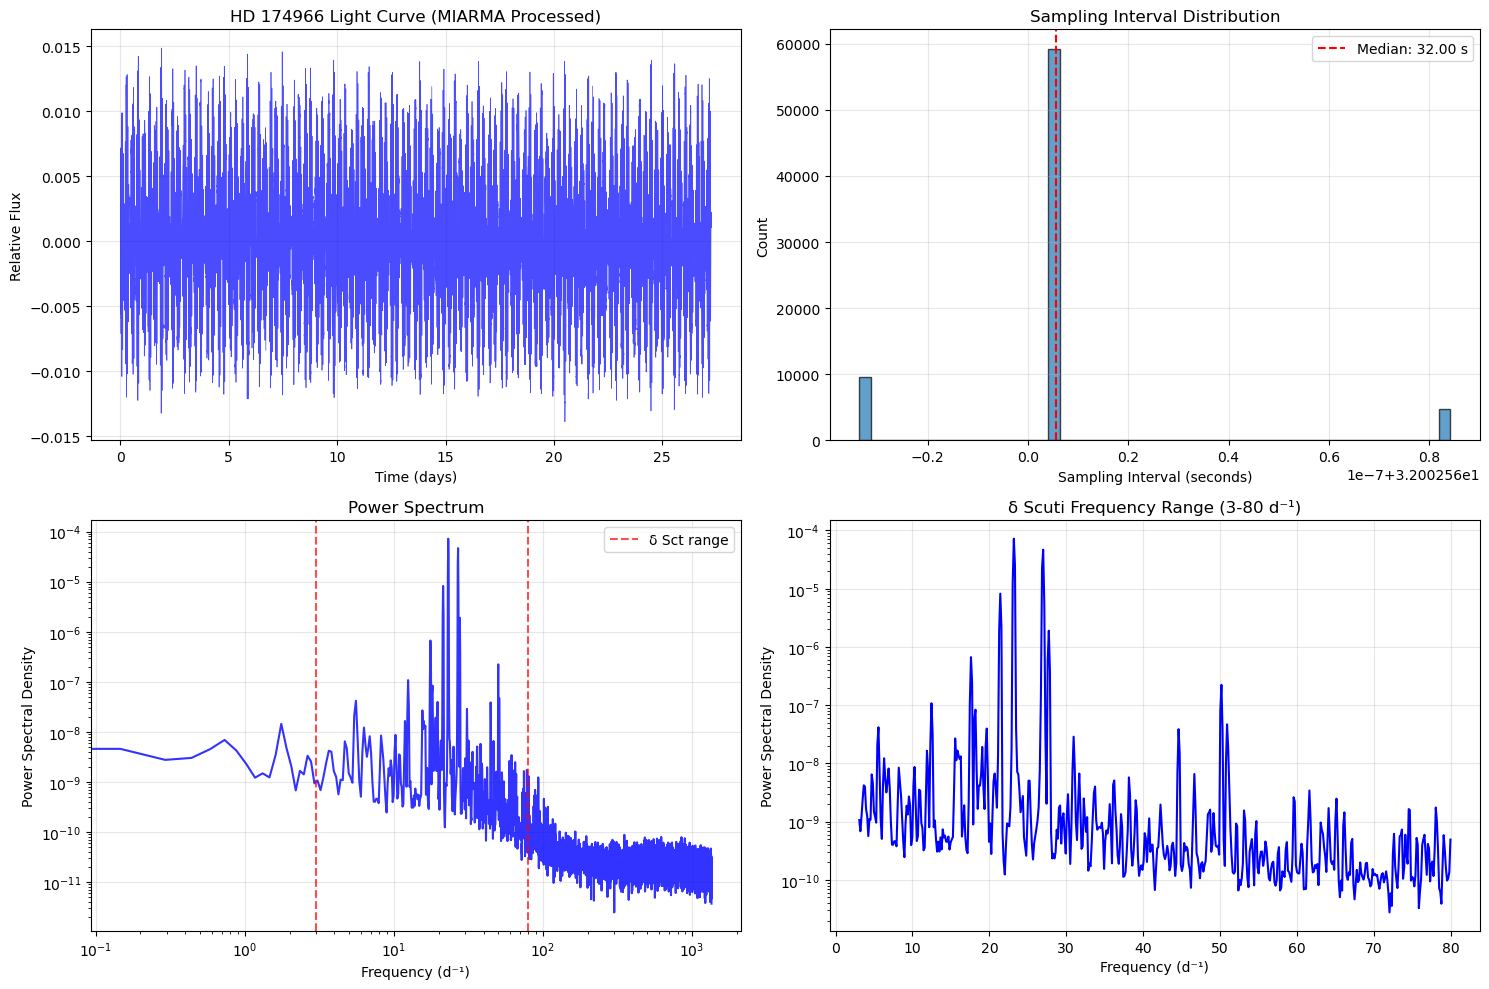

In [3]:
time, flux = load_mat_data()
assessment_results, time, flux, time_rel = comprehensive_data_quality_assessment()
fig = plot_quality_assessment_figures()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.ndimage import gaussian_filter
from ssqueezepy import ssq_cwt, cwt
from ssqueezepy.experimental import scale_to_freq

# ============ SSCWT Analysis Module ============

def ensure_ascending_freqs(freqs, power_2d):
    """
    Ensure frequencies are in ascending order and match power matrix
    
    Parameters:
    -----------
    freqs : array_like
        Frequency array
    power_2d : array_like
        Power matrix with frequency as first dimension
    
    Returns:
    --------
    tuple : (freqs_ascending, power_ascending)
    """
    freqs = np.asarray(freqs)
    if freqs.ndim != 1:
        raise ValueError("freqs must be 1D array")
    if power_2d.shape[0] != freqs.size:
        raise ValueError("power_2d first dimension must match freqs length")
    
    if freqs[0] > freqs[-1]:
        # Frequencies are descending, reverse both
        return freqs[::-1], power_2d[::-1, :]
    return freqs, power_2d


def run_cwt_analysis(time, flux, sigma=8, fmin=20.5, fmax=28.5, nf=400):
    """
    Perform CWT analysis following paper methodology
    
    Parameters:
    -----------
    time : array_like
        Time array in days
    flux : array_like
        Flux array
    sigma : float
        Morlet wavelet parameter
    fmin, fmax : float
        Frequency range in d^-1
    nf : int
        Number of frequency points
    
    Returns:
    --------
    tuple : (frequencies, power_matrix)
    """
    frequencies = np.linspace(fmin, fmax, nf)
    scales = sigma / (2 * np.pi * frequencies)
    
    N = len(flux)
    dt = np.median(np.diff(time))
    w = 2 * np.pi * fftfreq(N, d=dt)
    
    # Zero-mean normalization for MIARMA processed data
    flux_processed = flux - np.mean(flux)
    X = fft(flux_processed)
    
    W = np.zeros((len(scales), N), dtype=complex)
    
    print(f"CWT calculation: sigma={sigma}, frequency points={nf}")
    
    for i, a in enumerate(scales):
        if i % 100 == 0:
            print(f"Progress: {i}/{len(scales)}")
        
        # Standard Morlet wavelet
        psi_hat = np.exp(-0.5 * (a * w - sigma)**2) - np.exp(-0.5 * sigma**2) * np.exp(-0.5 * (a * w)**2)
        psi_hat *= np.pi**(-0.25) * np.sqrt(a)
        
        W[i, :] = ifft(X * np.conj(psi_hat))
    
    power = np.abs(W)**2
    
    # Light smoothing to preserve details
    power_smooth = gaussian_filter(power, sigma=[0.5, 0.3])
    
    return frequencies, power_smooth


def run_sscwt_analysis(time, flux, sigma=30, fmin=20.5, fmax=30.8, nv=None, gamma=1e-3,
                       cover_tol=0.05, nv_start=None, nv_step=32, nv_max=224):
    """
    Perform SSCWT analysis with adaptive frequency coverage
    
    Parameters:
    -----------
    time : array_like
        Time array in days
    flux : array_like
        Flux array
    sigma : float
        Morlet wavelet parameter
    fmin, fmax : float
        Target frequency range in d^-1
    nv : int or None
        Number of voices (if None, adaptive)
    gamma : float
        Threshold parameter for synchrosqueezing
    cover_tol : float
        Tolerance for frequency coverage
    nv_start : int
        Starting number of voices for adaptive search
    nv_step : int
        Step size for adaptive search
    nv_max : int
        Maximum number of voices
    
    Returns:
    --------
    tuple : (sscwt_freqs, cwt_freqs, cwt_power, sscwt_power)
    """
    x = flux - np.mean(flux)
    dt = np.median(np.diff(time))
    fs = 1.0 / dt
    nyq = fs / 2
    
    if fmax >= 0.98 * nyq:
        fmax = float(0.98 * nyq)  # Safety margin
    
    wavelet = ('morlet', {'mu': sigma})
    
    # Set nv search range
    if nv is not None:
        nv_try_list = [int(nv)]
    else:
        octaves = np.log2(max(1.0001, fmax / fmin))
        nv0 = max(64, int(80 / octaves)) if nv_start is None else int(nv_start)
        nv_try_list = list(range(nv0, nv_max + 1, nv_step))
    
    # Adaptive search for optimal frequency coverage
    last_res = None
    for nv_try in nv_try_list:
        try:
            res = ssq_cwt(x, wavelet=wavelet, nv=nv_try, fs=fs, gamma=gamma)
        except ValueError:
            # Fallback to library default for problematic nv values
            res = ssq_cwt(x, wavelet=wavelet, fs=fs, gamma=gamma)
        
        if len(res) == 4:
            Tx, Wx, ssq_freqs, scales = res
        else:
            Tx, Wx, ssq_freqs, scales, *_ = res
        
        # Calculate CWT frequencies for comparison
        Wx_cwt, scales_cwt = cwt(x, wavelet=wavelet, nv=nv_try, fs=fs)
        freqs_cwt = scale_to_freq(scales_cwt, wavelet, len(x), fs=fs)
        
        # Ensure ascending order
        freqs_cwt, power_cwt = ensure_ascending_freqs(freqs_cwt, np.abs(Wx_cwt)**2)
        ssq_freqs, power_ssq = ensure_ascending_freqs(ssq_freqs, np.abs(Tx)**2)
        
        last_res = (freqs_cwt, power_cwt, ssq_freqs, power_ssq, nv_try)
        
        # Check if target frequency coverage is achieved
        if ssq_freqs.max() >= fmax - cover_tol:
            break
    
    # Use effective maximum frequency to avoid empty regions
    fmax_eff = min(fmax, last_res[2].max())
    
    # Apply frequency masks
    cwt_mask = (last_res[0] >= fmin) & (last_res[0] <= fmax_eff)
    sscwt_mask = (last_res[2] >= fmin) & (last_res[2] <= fmax_eff)
    
    if not np.any(cwt_mask):
        raise ValueError(f"CWT frequency range {fmin}-{fmax_eff:.2f} d^-1 contains no data")
    if not np.any(sscwt_mask):
        raise ValueError(f"SSCWT frequency range {fmin}-{fmax_eff:.2f} d^-1 contains no data")
    
    return (last_res[2][sscwt_mask],      # sscwt_freqs
            last_res[0][cwt_mask],        # cwt_freqs
            last_res[1][cwt_mask, :],     # cwt_power
            last_res[3][sscwt_mask, :])   # sscwt_power


def calculate_scaled_frequency_points(fmin, fmax, ref_range=(20.5, 28.5), base_points=400):
    """
    Calculate number of frequency points scaled by bandwidth
    
    Parameters:
    -----------
    fmin, fmax : float
        Target frequency range
    ref_range : tuple
        Reference frequency range
    base_points : int
        Base number of points for reference range
    
    Returns:
    --------
    int : Scaled number of frequency points
    """
    fmin0, fmax0 = ref_range
    scale_factor = (fmax - fmin) / (fmax0 - fmin0)
    return max(256, int(round(base_points * scale_factor)))


def plot_sscwt_comparison(time, flux, save_figures=True, return_data=True):
    """
    Create Figure 1 style comparison plot with CWT and SSCWT analyses
    
    Parameters:
    -----------
    time : array_like
        Time array in days
    flux : array_like
        Flux array
    save_figures : bool
        Whether to save figures to file
    return_data : bool
        Whether to return analysis results
    
    Returns:
    --------
    dict or None : Analysis results if return_data=True
    """
    # Analysis configurations matching paper
    analysis_configs = {
        'A': dict(method='CWT',   sigma=8,  fmin=20.63, fmax=30.82, nv=None,  gamma=None),
        'B': dict(method='CWT',   sigma=30, fmin=19.99, fmax=30.07, nv=None,  gamma=None),
        'C': dict(method='SSCWT', sigma=8,  fmin=20.63, fmax=30.82, nv=96,    gamma=1e-3),
        'D': dict(method='SSCWT', sigma=30, fmin=19.99, fmax=30.07, nv=128,   gamma=5e-4),
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 11))
    time_rel = time - time[0]
    results = {}
    
    panels = [('A', (0,0)), ('B', (0,1)), ('C', (1,0)), ('D', (1,1))]
    
    for panel_id, (i, j) in panels:
        config = analysis_configs[panel_id]
        sigma, fmin_target, fmax_target = config['sigma'], config['fmin'], config['fmax']
        ax = axes[i, j]
        
        if config['method'] == 'CWT':
            nf = calculate_scaled_frequency_points(fmin_target, fmax_target)
            freqs, power = run_cwt_analysis(time, flux, sigma=sigma,
                                          fmin=fmin_target, fmax=fmax_target, nf=nf)
            fmin_eff, fmax_eff = float(freqs.min()), float(freqs.max())
            
            if fmax_eff < fmax_target - 1e-6:
                print(f"[{panel_id}] CWT max frequency {fmax_eff:.2f} d^-1 (target {fmax_target:.2f}), using actual limit")
            
            power_display = np.sqrt(power)
            vmax = np.percentile(power_display, 99.5)
            title = f"HD174966 Morlet Wavelet\n(σ = {sigma})"
            
        else:  # SSCWT
            freqs_ssc, freqs_cwt, power_cwt, power_ssc = run_sscwt_analysis(
                time, flux, sigma=sigma, fmin=fmin_target, fmax=fmax_target,
                nv=config['nv'], gamma=config['gamma']
            )
            freqs = freqs_ssc
            power = power_ssc
            fmin_eff, fmax_eff = float(freqs.min()), float(freqs.max())
            
            if fmax_eff < fmax_target - 1e-6:
                print(f"[{panel_id}] SSCWT max frequency {fmax_eff:.2f} d^-1 (target {fmax_target:.2f}), using actual limit")
            if fmin_eff > fmin_target + 1e-6:
                print(f"[{panel_id}] SSCWT min frequency {fmin_eff:.2f} d^-1 (target {fmin_target:.2f}), using actual limit")
            
            power_display = np.sqrt(power)
            vmax = np.percentile(power_display, 99.2 if sigma == 30 else 99.5)
            title = f"HD174966 Synchrosqueezed Morlet Wavelet\n(σ = {sigma})"
        
        # Create plot
        im = ax.imshow(power_display, 
                      extent=[time_rel.min(), time_rel.max(), fmin_eff, fmax_eff],
                      origin='lower', aspect='auto', cmap='seismic',
                      vmin=0, vmax=vmax, interpolation='bilinear')
        
        # Formatting
        ax.set_xlim(time_rel.min(), time_rel.max())
        ax.set_ylim(fmin_eff, fmax_eff)
        ax.set_xlabel("Time (d)")
        ax.set_ylabel("Frequency (d$^{-1}$)")
        
        # Add reference frequency lines
        reference_freqs = [21.32, 23.24, 27.01]
        for f0 in reference_freqs:
            if fmin_eff <= f0 <= fmax_eff:
                ax.axhline(f0, ls='--', lw=1.0, color='white', alpha=0.9)
        
        ax.set_title(title, fontsize=12)
        ax.grid(True, alpha=0.25, linestyle=':')
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.82)
        cbar.set_label("√Power (a.u.)")
        
        # Store results
        results[panel_id] = {
            'frequencies': freqs,
            'power': power,
            'method': config['method'],
            'sigma': sigma,
            'fmin_target': fmin_target,
            'fmax_target': fmax_target,
            'fmin_effective': fmin_eff,
            'fmax_effective': fmax_eff
        }
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig('figures/hd174966_sscwt_comparison.png', dpi=300, bbox_inches='tight')
        print("Figure saved to figures/hd174966_sscwt_comparison.png")
    
    plt.show()
    
    if return_data:
        results['time'] = time
        results['time_relative'] = time_rel
        return results
    
    return None


def print_frequency_range_summary(results):
    """
    Print summary of effective vs target frequency ranges
    
    Parameters:
    -----------
    results : dict
        Results from plot_sscwt_comparison()
    """
    print("\n=== Frequency Range Summary ===")
    for panel_id in ['A', 'B', 'C', 'D']:
        if panel_id in results:
            result = results[panel_id]
            print(f"{panel_id}: target [{result['fmin_target']:.2f}, {result['fmax_target']:.2f}] "
                  f"-> effective [{result['fmin_effective']:.2f}, {result['fmax_effective']:.2f}] d^-1")

CWT calculation: sigma=8, frequency points=510
Progress: 0/510
Progress: 100/510
Progress: 200/510
Progress: 300/510
Progress: 400/510
Progress: 500/510
CWT calculation: sigma=30, frequency points=504
Progress: 0/504
Progress: 100/504
Progress: 200/504
Progress: 300/504
Progress: 400/504
Progress: 500/504
[C] SSCWT max frequency 30.32 d^-1 (target 30.82), using actual limit
[C] SSCWT min frequency 20.70 d^-1 (target 20.63), using actual limit
[D] SSCWT max frequency 29.45 d^-1 (target 30.07), using actual limit
[D] SSCWT min frequency 20.37 d^-1 (target 19.99), using actual limit
Figure saved to figures/hd174966_sscwt_comparison.png


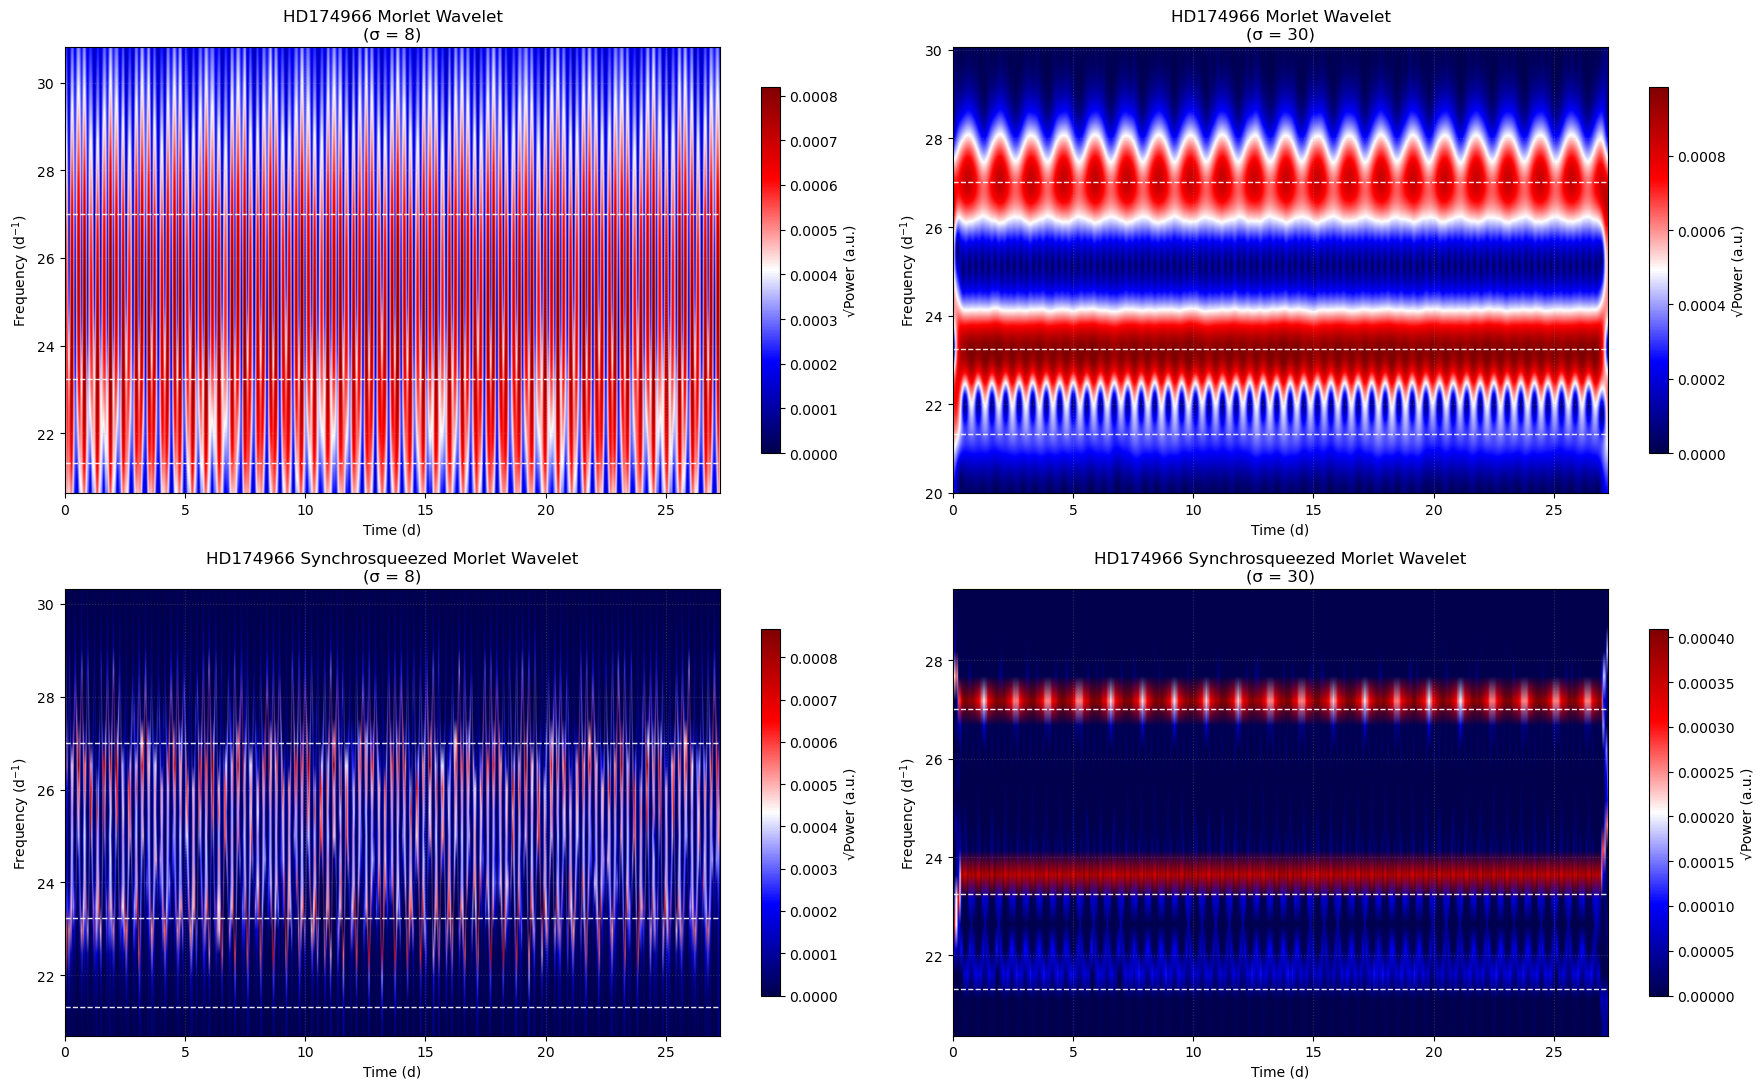


=== Frequency Range Summary ===
A: target [20.63, 30.82] -> effective [20.63, 30.82] d^-1
B: target [19.99, 30.07] -> effective [19.99, 30.07] d^-1
C: target [20.63, 30.82] -> effective [20.70, 30.32] d^-1
D: target [19.99, 30.07] -> effective [20.37, 29.45] d^-1


In [5]:

results = plot_sscwt_comparison(time, flux, save_figures=True, return_data=True)

print_frequency_range_summary(results)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ============ Frequency Analysis Module ============

def parabolic_interpolation(x, y, peak_index):
    """
    Perform parabolic interpolation around a peak to refine frequency estimate
    
    Parameters:
    -----------
    x : array_like
        Frequency array
    y : array_like
        Power array
    peak_index : int
        Index of the peak to refine
    
    Returns:
    --------
    tuple : (refined_frequency, refined_power)
    """
    x1, x2, x3 = x[peak_index-1], x[peak_index], x[peak_index+1]
    y1, y2, y3 = y[peak_index-1], y[peak_index], y[peak_index+1]
    
    denom = (y1 - 2*y2 + y3)
    if denom == 0:
        return x2, y2
    
    xp = x2 + 0.5 * (y1 - y3) / denom * (x3 - x1) / 2
    yp = y2 - 0.25 * (y1 - y3) * (xp - x2) * (2 / (x3 - x1))
    
    return xp, yp


def get_safe_band_indices(freqs, center_freq, half_bandwidth):
    """
    Get frequency indices within band, fallback to nearest neighbors if empty
    
    Parameters:
    -----------
    freqs : array_like
        Frequency array
    center_freq : float
        Center frequency
    half_bandwidth : float
        Half bandwidth
    
    Returns:
    --------
    array : Frequency indices within band
    """
    freqs = np.asarray(freqs)
    
    # Ensure ascending order
    if freqs[0] > freqs[-1]:
        freqs = freqs[::-1]
    
    # Calculate effective bandwidth
    df = np.median(np.diff(freqs))
    half_bw_eff = max(half_bandwidth, df)
    
    # Find band indices
    band_mask = (freqs >= center_freq - half_bw_eff) & (freqs <= center_freq + half_bw_eff)
    indices = np.where(band_mask)[0]
    
    # Fallback to nearest neighbor if empty
    if indices.size == 0:
        nearest_idx = int(np.argmin(np.abs(freqs - center_freq)))
        lo = max(0, nearest_idx - 1)
        hi = min(len(freqs) - 1, nearest_idx + 1)
        indices = np.arange(lo, hi + 1)
    
    return indices


def refine_peak_in_band(freqs, power_2d, target_freq, half_bw=0.15, use_max_over_time=False):
    """
    Find and refine peak frequency within specified band
    
    Parameters:
    -----------
    freqs : array_like
        Frequency array
    power_2d : array_like
        2D power array (frequency x time)
    target_freq : float
        Target frequency
    half_bw : float
        Half bandwidth
    use_max_over_time : bool
        Use max over time instead of mean
    
    Returns:
    --------
    tuple : (refined_freq, refined_power, band_freqs, band_spectrum)
    """
    freqs = np.asarray(freqs)
    power = np.asarray(power_2d)
    
    if freqs[0] > freqs[-1]:
        freqs = freqs[::-1]
        power = power[::-1, :]

    indices = get_safe_band_indices(freqs, target_freq, half_bw)
    band_freqs = freqs[indices]
    
    spectrum = (np.max(power[indices, :], axis=1) if use_max_over_time
                else np.mean(power[indices, :], axis=1))

    # Find peaks
    peaks, _ = find_peaks(spectrum)
    if peaks.size == 0:
        peak_idx = int(np.argmax(spectrum))
        return band_freqs[peak_idx], spectrum[peak_idx], band_freqs, spectrum

    # Select peak closest to target
    closest_peak_idx = peaks[np.argmin(np.abs(band_freqs[peaks] - target_freq))]
    
    # Apply parabolic interpolation if possible
    if 0 < closest_peak_idx < len(band_freqs) - 1:
        refined_freq, refined_power = parabolic_interpolation(
            band_freqs, spectrum, closest_peak_idx)
    else:
        refined_freq = band_freqs[closest_peak_idx]
        refined_power = spectrum[closest_peak_idx]
        
    return refined_freq, refined_power, band_freqs, spectrum


def band_power_timeseries(freqs, power_2d, f_center, half_bw=0.15, agg='mean'):
    """
    Extract band power time series
    
    Parameters:
    -----------
    freqs : array_like
        Frequency array
    power_2d : array_like
        2D power array
    f_center : float
        Center frequency
    half_bw : float
        Half bandwidth
    agg : str
        Aggregation method ('mean' or 'max')
    
    Returns:
    --------
    array : Power time series
    """
    freqs = np.asarray(freqs)
    power = np.asarray(power_2d)
    
    if freqs[0] > freqs[-1]:
        freqs = freqs[::-1]
        power = power[::-1, :]

    indices = get_safe_band_indices(freqs, f_center, half_bw)
    
    if agg == 'mean':
        return np.mean(power[indices, :], axis=0)
    elif agg == 'max':
        return np.max(power[indices, :], axis=0)
    else:
        raise ValueError("agg must be 'mean' or 'max'")


def detect_sscwt_artifacts_peak(results, artifact_freqs, half_bw=0.15, power_thresh_percentile=90):
    """
    Detect SSCWT artifacts using peak power detection
    
    Parameters:
    -----------
    results : dict
        SSCWT results dictionary
    artifact_freqs : list
        List of frequencies to check for artifacts
    half_bw : float
        Half bandwidth for detection
    power_thresh_percentile : float
        Power threshold percentile
    """
    time_rel = results['time_rel']
    freqs_ssc = results['sigma30']['sscwt']['freqs']
    power_ssc = np.sqrt(results['sigma30']['sscwt']['power'])

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    extent_ssc = [time_rel.min(), time_rel.max(), freqs_ssc.min(), freqs_ssc.max()]
    vmax_ssc = np.percentile(power_ssc, 99.5)

    im = ax.imshow(power_ssc, extent=extent_ssc, aspect='auto', origin='lower',
                   cmap='seismic', vmin=0, vmax=vmax_ssc, interpolation='bilinear')
    plt.colorbar(im, ax=ax, label="√Power (a.u.)")

    global_thresh = np.percentile(power_ssc, power_thresh_percentile)

    for f0 in artifact_freqs:
        mask_band = (freqs_ssc >= f0 - half_bw) & (freqs_ssc <= f0 + half_bw)
        if not np.any(mask_band):
            print(f"Warning: No data points in range {f0:.2f} ± {half_bw} d^-1")
            continue

        band_peak = np.max(power_ssc[mask_band, :])
        is_artifact = band_peak >= global_thresh

        ax.axhline(f0, color='cyan' if is_artifact else 'gray', ls='--', lw=1.5, alpha=0.9)
        ax.text(time_rel.min() + 0.5, f0 + 0.05,
                f"{f0:.2f} d^-1\n{'artifact' if is_artifact else 'low'}",
                color='cyan' if is_artifact else 'gray', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.6))

        print(f"{f0:.2f} d^-1 peak power: {band_peak:.4f} {'[artifact]' if is_artifact else '[low]'}")

    ax.set_title("SSCWT σ=30: artifact detection by peak power")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Frequency (d^-1)")
    ax.grid(True, alpha=0.3, linestyle=':', color='gray')
    plt.tight_layout()
    plt.show()


def extract_frequencies_simple(freqs, power_2d, n_top=5, time_average=True):
    """
    Simple frequency extraction function
    
    Parameters:
    -----------
    freqs : array_like
        Frequency array
    power_2d : array_like
        2D power array (frequency x time)
    n_top : int
        Number of top frequencies to extract
    time_average : bool
        Whether to average over time
    
    Returns:
    --------
    tuple : (top_frequencies, top_powers)
    """
    if time_average:
        # Average over time axis
        mean_power = np.mean(power_2d, axis=1)
    else:
        # Use maximum values
        mean_power = np.max(power_2d, axis=1)
    
    # Find peaks
    peaks, properties = find_peaks(mean_power, 
                                  prominence=0.2*np.max(mean_power),
                                  distance=5)
    
    if len(peaks) == 0:
        print("Warning: No significant peaks found")
        return np.array([]), np.array([])
    
    # Sort by power
    peak_powers = mean_power[peaks]
    sorted_idx = np.argsort(peak_powers)[::-1]
    
    # Take top n
    n_found = min(n_top, len(peaks))
    top_idx = peaks[sorted_idx[:n_found]]
    top_frequencies = freqs[top_idx]
    top_powers = mean_power[top_idx]
    
    return top_frequencies, top_powers

In [7]:
# ============ Frequency Analysis Calls ============

# Use results from plot_sscwt_comparison or plot_figure1_paper_ranges_auto_ylim

# CWT σ=30: from Panel B
freqs_cwt30 = results['B']['freqs'] if 'freqs' in results['B'] else results['B']['frequencies']
power_cwt30 = results['B']['power']
top_freqs_cwt, top_powers_cwt = extract_frequencies_simple(freqs_cwt30, power_cwt30, n_top=5)
print("\nCWT σ=30 (Panel B) Top peaks:")
for i, (f, p) in enumerate(zip(top_freqs_cwt, top_powers_cwt), 1):
    print(f"  {i}. {f:.4f} d⁻¹ (power={p:.3e})")

# SSCWT σ=30: from Panel D
freqs_ssc30 = results['D']['freqs'] if 'freqs' in results['D'] else results['D']['frequencies']
power_ssc30 = results['D']['power']
top_freqs_ssc, top_powers_ssc = extract_frequencies_simple(freqs_ssc30, power_ssc30, n_top=5)
print("\nSSCWT σ=30 (Panel D) Top peaks:")
for i, (f, p) in enumerate(zip(top_freqs_ssc, top_powers_ssc), 1):
    print(f"  {i}. {f:.4f} d⁻¹ (power={p:.3e})")

# Target frequencies for refinement
targets = [21.32, 23.24, 27.01]
half_bw = 0.15

print("\nCWT σ=30 (Panel B) — refined peaks near targets:")
for f0 in targets:
    f_peak, ypk, *_ = refine_peak_in_band(freqs_cwt30, power_cwt30, f0, half_bw=half_bw)
    print(f"  target {f0:.2f} → {f_peak:.4f} d⁻¹")

print("\nSSCWT σ=30 (Panel D) — refined peaks near targets:")
for f0 in targets:
    f_peak, ypk, *_ = refine_peak_in_band(freqs_ssc30, power_ssc30, f0, half_bw=half_bw)
    print(f"  target {f0:.2f} → {f_peak:.4f} d⁻¹")


CWT σ=30 (Panel B) Top peaks:
  1. 23.1763 d⁻¹ (power=9.239e-07)
  2. 26.9438 d⁻¹ (power=5.621e-07)

SSCWT σ=30 (Panel D) Top peaks:
  1. 23.1965 d⁻¹ (power=1.328e-07)
  2. 26.9998 d⁻¹ (power=1.174e-07)

CWT σ=30 (Panel B) — refined peaks near targets:
  target 21.32 → 21.4529 d⁻¹
  target 23.24 → 23.1802 d⁻¹
  target 27.01 → 26.9534 d⁻¹

SSCWT σ=30 (Panel D) — refined peaks near targets:
  target 21.32 → 21.3628 d⁻¹
  target 23.24 → 23.1965 d⁻¹
  target 27.01 → 26.9998 d⁻¹


In [8]:
# ============ Time Series and Artifact Analysis ============

import matplotlib.pyplot as plt
import numpy as np

def plot_band_power_timeseries(sscwt_results, target_frequencies, half_bandwidth=0.15, 
                              panels=['B', 'D'], save_figure=True):
    """
    Plot power time series for target frequency bands
    
    Parameters:
    -----------
    sscwt_results : dict
        Results from plot_sscwt_comparison()
    target_frequencies : list
        Target frequencies to analyze
    half_bandwidth : float
        Half bandwidth for frequency bands
    panels : list
        Panel IDs to plot
    save_figure : bool
        Whether to save the figure
    """
    time_axis = sscwt_results['time']
    
    fig, axes = plt.subplots(len(panels), 1, figsize=(12, 4*len(panels)), sharex=True)
    if len(panels) == 1:
        axes = [axes]
    
    panel_info = {
        'B': {'method': 'CWT', 'sigma': 30},
        'D': {'method': 'SSCWT', 'sigma': 30}
    }
    
    for idx, panel_id in enumerate(panels):
        if panel_id not in sscwt_results:
            print(f"Warning: Panel {panel_id} not found in results")
            continue
            
        freqs = sscwt_results[panel_id]['frequencies']
        power_2d = sscwt_results[panel_id]['power']
        
        ax = axes[idx]
        
        # Plot power time series for each target frequency
        for freq in target_frequencies:
            power_timeseries = band_power_timeseries(freqs, power_2d, freq, half_bandwidth)
            ax.plot(time_axis, power_timeseries, label=f"{freq:.2f} d⁻¹", linewidth=1.5)
        
        # Format subplot
        method = panel_info[panel_id]['method']
        sigma = panel_info[panel_id]['sigma']
        ax.set_ylabel("Power")
        ax.set_title(f"{method} σ={sigma} — Target frequency bands power vs time")
        ax.legend()
        ax.grid(alpha=0.3)
    
    # Set x-label for bottom subplot
    axes[-1].set_xlabel("Time [days]")
    
    plt.tight_layout()
    
    if save_figure:
        plt.savefig('figures/band_power_timeseries.png', dpi=300, bbox_inches='tight')
        print("Band power time series figure saved to figures/band_power_timeseries.png")
    
    plt.show()
    
    return fig


def detect_and_analyze_artifacts(sscwt_results, artifact_frequencies, half_bandwidth=0.15):
    """
    Detect SSCWT artifacts and return analysis results
    
    Parameters:
    -----------
    sscwt_results : dict
        Results from plot_sscwt_comparison()
    artifact_frequencies : list
        Target artifact frequencies to check
    half_bandwidth : float
        Half bandwidth for artifact detection
    
    Returns:
    --------
    list : Detection results for each artifact frequency
    """
    # Use Panel D (SSCWT σ=30) for artifact detection
    freqs_ssc30 = sscwt_results['D']['frequencies']
    power_ssc30 = sscwt_results['D']['power']
    
    # Calculate time-averaged power spectrum
    mean_power_ssc = np.mean(power_ssc30, axis=1)
    
    print(f"\n=== SSCWT Artifact Detection Results (σ=30) ===")
    
    detected_artifacts = []
    
    for target_freq in artifact_frequencies:
        # Create frequency mask for artifact band
        freq_mask = ((freqs_ssc30 >= target_freq - half_bandwidth) & 
                    (freqs_ssc30 <= target_freq + half_bandwidth))
        
        if np.any(freq_mask):
            local_freqs = freqs_ssc30[freq_mask]
            local_power = mean_power_ssc[freq_mask]
            peak_idx = np.argmax(local_power)
            
            detected_artifacts.append({
                'target': target_freq,
                'detected_frequency': local_freqs[peak_idx],
                'power': local_power[peak_idx]
            })
            
            print(f"{target_freq:.2f} d⁻¹ → detected {local_freqs[peak_idx]:.3f} d⁻¹ "
                  f"(power {local_power[peak_idx]:.2e})")
        else:
            detected_artifacts.append({
                'target': target_freq,
                'detected_frequency': None,
                'power': None
            })
            print(f"{target_freq:.2f} d⁻¹: No data in frequency range")
    
    return detected_artifacts


def calculate_artifact_metrics(freqs, power_2d, candidate_frequencies,
                              half_bandwidth=0.15, per_time_quantile=0.85, 
                              background_quantile=0.75):
    """
    Calculate artifact metrics for candidate frequencies
    
    Parameters:
    -----------
    freqs : array_like
        Frequency array
    power_2d : array_like
        2D power array (frequency x time)
    candidate_frequencies : list
        Frequencies to analyze for artifacts
    half_bandwidth : float
        Half bandwidth for frequency bands
    per_time_quantile : float
        Quantile threshold for persistence calculation
    background_quantile : float
        Quantile for background estimation
    
    Returns:
    --------
    pandas.DataFrame : Artifact metrics for each frequency
    """
    import pandas as pd
    
    # Ensure ascending frequency order
    if freqs[0] > freqs[-1]:
        freqs = freqs[::-1]
        power_2d = power_2d[::-1, :]

    # Use sqrt(power) for analysis
    sqrt_power = np.sqrt(power_2d)
    n_time = sqrt_power.shape[1]
    
    # Calculate adaptive threshold for each time slice
    column_threshold = np.quantile(sqrt_power, per_time_quantile, axis=0)

    results = []
    
    for freq in candidate_frequencies:
        # Find frequency band indices
        band_mask = (freqs >= freq - half_bandwidth) & (freqs <= freq + half_bandwidth)
        band_indices = np.where(band_mask)[0]
        
        if band_indices.size == 0:
            results.append({
                'frequency': freq,
                'status': 'out_of_range',
                'persistence': 0.0,
                'PBR': np.nan,
                'peak': 0.0
            })
            continue

        # Extract band time series (maximum in band at each time)
        band_timeseries = np.max(sqrt_power[band_indices, :], axis=0)
        
        # Calculate persistence (fraction of time above adaptive threshold)
        persistence = float(np.mean(band_timeseries >= column_threshold))
        
        # Calculate peak value
        peak_value = float(np.max(band_timeseries))

        # Calculate Peak-to-Background Ratio (PBR)
        # Background from neighboring regions: [f-0.6, f-0.25] ∪ [f+0.25, f+0.6]
        neighbor_mask = (((freqs >= freq - 0.6) & (freqs <= freq - 0.25)) |
                        ((freqs >= freq + 0.25) & (freqs <= freq + 0.6)))
        neighbor_indices = np.where(neighbor_mask)[0]
        
        if neighbor_indices.size > 0:
            background_level = float(np.quantile(sqrt_power[neighbor_indices, :], background_quantile))
            pbr = (peak_value / background_level) if background_level > 0 else np.inf
        else:
            pbr = np.nan

        results.append({
            'frequency': freq,
            'status': 'ok',
            'persistence': persistence,
            'PBR': pbr,
            'peak': peak_value
        })
    
    return pd.DataFrame(results)


# ============ Analysis Execution Functions ============

def run_band_power_analysis(sscwt_results, target_frequencies=None, half_bandwidth=0.15):
    """
    Run band power time series analysis
    
    Parameters:
    -----------
    sscwt_results : dict
        Results from plot_sscwt_comparison()
    target_frequencies : list or None
        Target frequencies (default: paper frequencies)
    half_bandwidth : float
        Half bandwidth for analysis
    """
    if target_frequencies is None:
        target_frequencies = [21.32, 23.24, 27.01]  # Paper target frequencies
    
    print("=== Band Power Time Series Analysis ===")
    print(f"Target frequencies: {target_frequencies}")
    print(f"Half bandwidth: ±{half_bandwidth} d⁻¹")
    
    # Plot time series for CWT and SSCWT
    fig = plot_band_power_timeseries(
        sscwt_results, target_frequencies, half_bandwidth, 
        panels=['B', 'D'], save_figure=True)
    
    return fig


def run_artifact_detection_analysis(sscwt_results, artifact_frequencies=None, 
                                   observed_frequencies=None, half_bandwidth=0.15):
    """
    Run comprehensive SSCWT artifact detection and analysis
    
    Parameters:
    -----------
    sscwt_results : dict
        Results from plot_sscwt_comparison()
    artifact_frequencies : list or None
        Paper-listed artifact frequencies (default: [24.2, 25.3, 28.7])
    observed_frequencies : list or None
        Actually observed artifact frequencies
    half_bandwidth : float
        Half bandwidth for detection
    
    Returns:
    --------
    dict : Complete artifact analysis results
    """
    if artifact_frequencies is None:
        artifact_frequencies = [24.20, 25.30, 28.70]  # Paper artifact positions
    
    print("=== SSCWT Artifact Detection and Analysis ===")
    print(f"Paper artifact frequencies: {artifact_frequencies}")
    print(f"Half bandwidth: ±{half_bandwidth} d⁻¹")
    
    # Get Panel D data (SSCWT σ=30)
    freqs_ssc30 = sscwt_results['D']['frequencies']
    power_ssc30 = sscwt_results['D']['power']
    
    # Step 1: Basic artifact detection
    detection_results = detect_and_analyze_artifacts(
        sscwt_results, artifact_frequencies, half_bandwidth)
    
    # Step 2: Calculate metrics for paper-listed artifacts
    print("\n=== Paper-listed Artifact Metrics (σ=30, SSCWT) ===")
    paper_metrics = calculate_artifact_metrics(
        freqs_ssc30, power_ssc30, artifact_frequencies,
        half_bandwidth=0.15, per_time_quantile=0.85, background_quantile=0.75)
    print(paper_metrics.to_string(index=False))
    
    # Step 3: If observed frequencies provided, analyze them too
    observed_metrics = None
    if observed_frequencies is not None:
        print(f"\nObserved artifact frequencies: {observed_frequencies}")
        print("\n=== Observed Artifact Metrics (σ=30, SSCWT) ===")
        observed_metrics = calculate_artifact_metrics(
            freqs_ssc30, power_ssc30, observed_frequencies,
            half_bandwidth=0.10, per_time_quantile=0.85, background_quantile=0.75)
        print(observed_metrics.to_string(index=False))
    
    # Compile results
    analysis_results = {
        'detection_results': detection_results,
        'paper_metrics': paper_metrics,
        'observed_metrics': observed_metrics,
        'parameters': {
            'artifact_frequencies': artifact_frequencies,
            'observed_frequencies': observed_frequencies,
            'half_bandwidth': half_bandwidth
        }
    }
    
    return analysis_results

=== Band Power Time Series Analysis ===
Target frequencies: [21.32, 23.24, 27.01]
Half bandwidth: ±0.15 d⁻¹
Band power time series figure saved to figures/band_power_timeseries.png


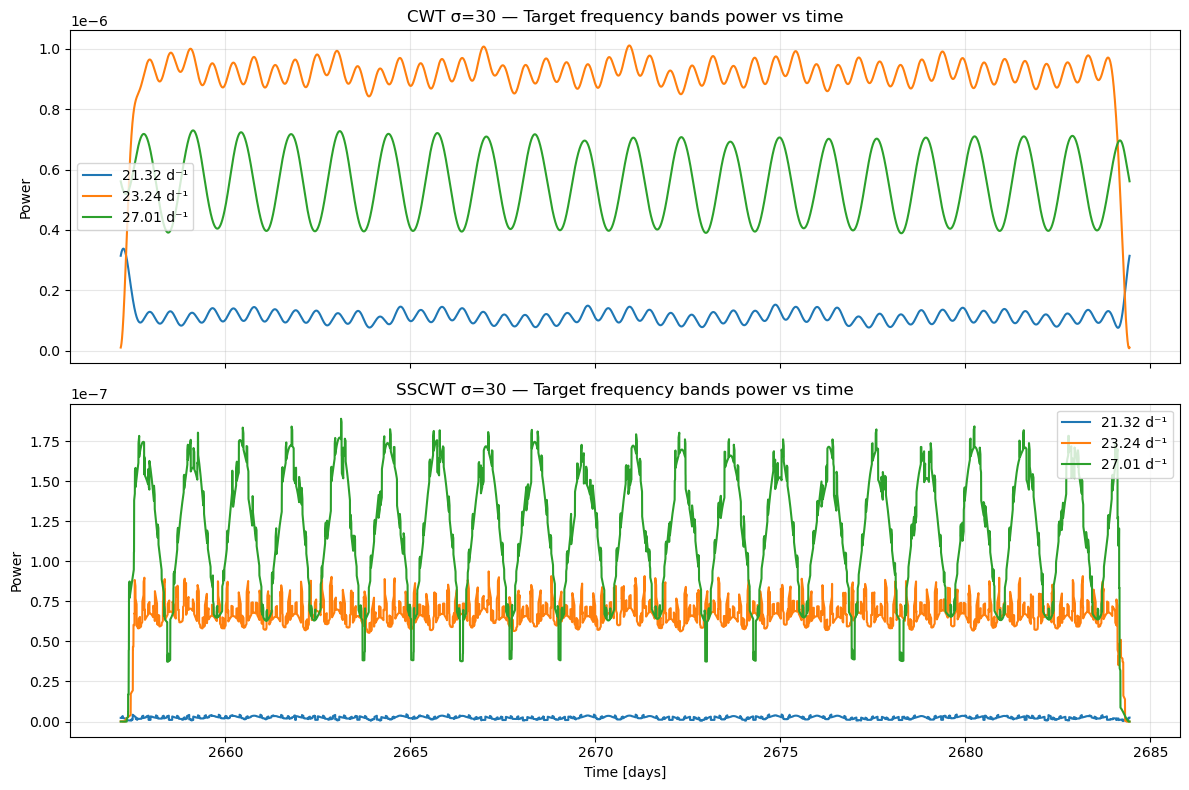

In [9]:

target_freqs = [21.32, 23.24, 27.01]
band_power_fig = run_band_power_analysis(results, target_freqs, half_bandwidth=0.15)


In [10]:
paper_artifacts = [24.20, 25.30, 28.70]
observed_artifacts = [24.225, 25.299, 28.815] 

artifact_analysis = run_artifact_detection_analysis(
    results, 
    artifact_frequencies=paper_artifacts,
    observed_frequencies=observed_artifacts,
    half_bandwidth=0.15
)

=== SSCWT Artifact Detection and Analysis ===
Paper artifact frequencies: [24.2, 25.3, 28.7]
Half bandwidth: ±0.15 d⁻¹

=== SSCWT Artifact Detection Results (σ=30) ===
24.20 d⁻¹ → detected 24.225 d⁻¹ (power 4.43e-10)
25.30 d⁻¹ → detected 25.299 d⁻¹ (power 9.24e-11)
28.70 d⁻¹ → detected 28.815 d⁻¹ (power 7.41e-12)

=== Paper-listed Artifact Metrics (σ=30, SSCWT) ===
 frequency status  persistence       PBR     peak
      24.2     ok     0.005841 19.308493 0.000265
      25.3     ok     0.002282       inf 0.000160
      28.7     ok     0.000000       inf 0.000054

Observed artifact frequencies: [24.225, 25.299, 28.815]

=== Observed Artifact Metrics (σ=30, SSCWT) ===
 frequency status  persistence       PBR     peak
    24.225     ok     0.005841 19.308493 0.000265
    25.299     ok     0.002282       inf 0.000160
    28.815     ok     0.000000       NaN 0.000054


In [11]:
# ============ Synthetic Data Analysis Module ============

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def find_frequency_peaks_fft(time, flux, fmin=4.46, fmax=6.71, n_peaks=8, prominence_fraction=0.15):
    """
    Find frequency peaks in specified band using FFT power spectrum
    
    Parameters:
    -----------
    time : array_like
        Time array (assumes regular sampling from MIARMA processing)
    flux : array_like
        Flux array
    fmin, fmax : float
        Frequency range in d^-1
    n_peaks : int
        Maximum number of peaks to return
    prominence_fraction : float
        Prominence threshold as fraction of maximum power
    
    Returns:
    --------
    array : Candidate frequencies in d^-1
    """
    # Prepare signal
    signal = flux - np.mean(flux)
    dt = np.median(np.diff(time))
    sampling_frequency = 1.0 / dt  # d^-1
    
    # Calculate FFT power spectrum
    frequencies = np.fft.rfftfreq(signal.size, d=dt)
    fft_spectrum = np.fft.rfft(signal)
    power = np.abs(fft_spectrum)**2

    # Apply frequency band mask
    band_mask = (frequencies >= fmin) & (frequencies <= fmax)
    if not np.any(band_mask):
        print(f"Warning: No data in frequency range [{fmin:.2f}, {fmax:.2f}] d^-1")
        return np.array([])

    # Extract band data
    band_power = power[band_mask]
    band_frequencies = frequencies[band_mask]
    
    # Find peaks with prominence threshold
    prominence_threshold = float(np.max(band_power) * prominence_fraction)
    peaks, _ = find_peaks(band_power, prominence=prominence_threshold)
    
    if len(peaks) == 0:
        print("Warning: No peaks found with current prominence threshold")
        return np.array([])
    
    # Get candidate frequencies
    candidate_freqs = band_frequencies[peaks]
    
    # Sort by power (highest first)
    peak_powers = band_power[peaks]
    sorted_indices = np.argsort(peak_powers)[::-1]
    candidate_freqs = candidate_freqs[sorted_indices]
    
    # Limit number of peaks
    if candidate_freqs.size > n_peaks:
        candidate_freqs = candidate_freqs[:n_peaks]
    
    # Round and remove duplicates
    candidate_freqs = np.unique(np.round(candidate_freqs, 6))
    
    print(f"Found {len(candidate_freqs)} frequency peaks in range [{fmin:.2f}, {fmax:.2f}] d^-1")
    return candidate_freqs


def fit_sinusoidal_model(time, flux, frequencies):
    """
    Fit sinusoidal model with fixed frequencies using linear least squares
    
    Model: y(t) = sum_k [A_k * sin(2π f_k t) + B_k * cos(2π f_k t)]
    
    Parameters:
    -----------
    time : array_like
        Time array
    flux : array_like
        Flux array
    frequencies : array_like
        Fixed frequencies for fitting (d^-1)
    
    Returns:
    --------
    tuple : (amplitudes, phases) where y(t) = sum_k amplitudes_k * sin(2π f_k t + phases_k)
    """
    # Prepare signal (zero-mean)
    signal = flux - np.mean(flux)
    n_freqs = len(frequencies)
    n_time = len(time)
    
    # Build design matrix: [sin(f1*t), cos(f1*t), ..., sin(fM*t), cos(fM*t)]
    design_matrix = np.zeros((n_time, 2 * n_freqs), dtype=float)
    
    for i, freq in enumerate(frequencies):
        angular_freq = 2 * np.pi * freq
        design_matrix[:, 2*i] = np.sin(angular_freq * time)
        design_matrix[:, 2*i + 1] = np.cos(angular_freq * time)
    
    # Solve linear least squares
    coefficients, residuals, rank, singular_values = np.linalg.lstsq(
        design_matrix, signal, rcond=None)
    
    # Extract amplitudes and phases
    sin_coeffs = coefficients[0::2]  # A_k coefficients
    cos_coeffs = coefficients[1::2]  # B_k coefficients
    
    amplitudes = np.sqrt(sin_coeffs**2 + cos_coeffs**2)
    phases = np.arctan2(cos_coeffs, sin_coeffs)  # Phase for sin form
    
    # Calculate fit quality
    residual_rms = np.sqrt(np.mean(residuals)) if len(residuals) > 0 else 0
    
    print(f"Fitted {n_freqs} sinusoidal components")
    print(f"Residual RMS: {residual_rms:.6f}")
    
    return amplitudes, phases


def synthesize_light_curve(time, frequencies, amplitudes, phases):
    """
    Synthesize light curve from sinusoidal components
    
    Parameters:
    -----------
    time : array_like
        Time array
    frequencies : array_like
        Component frequencies (d^-1)
    amplitudes : array_like
        Component amplitudes
    phases : array_like
        Component phases
    
    Returns:
    --------
    array : Synthesized flux time series
    """
    synthetic_flux = np.zeros_like(time, dtype=float)
    
    for freq, amp, phase in zip(frequencies, amplitudes, phases):
        synthetic_flux += amp * np.sin(2 * np.pi * freq * time + phase)
    
    print(f"Synthesized light curve with {len(frequencies)} frequency components")
    return synthetic_flux


def plot_figure4_comparison(time, real_flux, synthetic_flux, 
                           fmin=4.46, fmax=6.71, sigma_cwt=30, sigma_sscwt=30,
                           save_figure=True):
    """
    Create Figure 4 style comparison: Real vs Synthetic CWT/SSCWT
    
    Parameters:
    -----------
    time : array_like
        Time array
    real_flux : array_like
        Real observed flux
    synthetic_flux : array_like
        Synthesized flux
    fmin, fmax : float
        Frequency range for analysis
    sigma_cwt, sigma_sscwt : float
        Morlet wavelet parameters
    save_figure : bool
        Whether to save the figure
    """
    print("Generating Figure 4 comparison plots...")
    
    # Calculate time-frequency analyses
    print("Computing real data CWT...")
    freqs_real_cwt, power_real_cwt = run_cwt_analysis(
        time, real_flux, sigma=sigma_cwt, fmin=fmin, fmax=fmax, nf=400)
    
    print("Computing synthetic data CWT...")
    freqs_synth_cwt, power_synth_cwt = run_cwt_analysis(
        time, synthetic_flux, sigma=sigma_cwt, fmin=fmin, fmax=fmax, nf=400)
    
    print("Computing real data SSCWT...")
    freqs_real_sscwt, _, _, power_real_sscwt = run_sscwt_analysis(
        time, real_flux, sigma=sigma_sscwt, fmin=fmin, fmax=fmax, nv=None, gamma=1e-8)
    
    print("Computing synthetic data SSCWT...")
    freqs_synth_sscwt, _, _, power_synth_sscwt = run_sscwt_analysis(
        time, synthetic_flux, sigma=sigma_sscwt, fmin=fmin, fmax=fmax, nv=None, gamma=1e-8)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    time_rel = time - time[0]
    
    # Panel A: Real CWT
    power_display = np.sqrt(power_real_cwt)
    vmax = np.percentile(power_display, 99.5)
    im = axes[0,0].imshow(power_display, 
                         extent=[time_rel.min(), time_rel.max(), fmin, fmax],
                         origin='lower', aspect='auto', cmap='seismic',
                         vmin=0, vmax=vmax, interpolation='bilinear')
    axes[0,0].set_title(f"Real Data CWT (σ={sigma_cwt})")
    axes[0,0].set_ylabel("Frequency (d$^{-1}$)")
    plt.colorbar(im, ax=axes[0,0], shrink=0.85, label="√Power (a.u.)")
    
    # Panel B: Synthetic CWT
    power_display = np.sqrt(power_synth_cwt)
    vmax = np.percentile(power_display, 99.5)
    im = axes[0,1].imshow(power_display,
                         extent=[time_rel.min(), time_rel.max(), fmin, fmax],
                         origin='lower', aspect='auto', cmap='seismic',
                         vmin=0, vmax=vmax, interpolation='bilinear')
    axes[0,1].set_title(f"Synthetic Data CWT (σ={sigma_cwt})")
    plt.colorbar(im, ax=axes[0,1], shrink=0.85, label="√Power (a.u.)")
    
    # Panel C: Real SSCWT
    power_display = np.sqrt(power_real_sscwt)
    vmax = np.percentile(power_display, 99.2)  # Slightly lower for better visibility
    im = axes[1,0].imshow(power_display,
                         extent=[time_rel.min(), time_rel.max(), 
                                freqs_real_sscwt.min(), freqs_real_sscwt.max()],
                         origin='lower', aspect='auto', cmap='seismic',
                         vmin=0, vmax=vmax, interpolation='bilinear')
    axes[1,0].set_title(f"Real Data SSCWT (σ={sigma_sscwt})")
    axes[1,0].set_xlabel("Time (d)")
    axes[1,0].set_ylabel("Frequency (d$^{-1}$)")
    plt.colorbar(im, ax=axes[1,0], shrink=0.85, label="√Power (a.u.)")
    
    # Panel D: Synthetic SSCWT
    power_display = np.sqrt(power_synth_sscwt)
    vmax = np.percentile(power_display, 99.2)
    im = axes[1,1].imshow(power_display,
                         extent=[time_rel.min(), time_rel.max(),
                                freqs_synth_sscwt.min(), freqs_synth_sscwt.max()],
                         origin='lower', aspect='auto', cmap='seismic',
                         vmin=0, vmax=vmax, interpolation='bilinear')
    axes[1,1].set_title(f"Synthetic Data SSCWT (σ={sigma_sscwt})")
    axes[1,1].set_xlabel("Time (d)")
    plt.colorbar(im, ax=axes[1,1], shrink=0.85, label="√Power (a.u.)")
    
    # Add reference frequency lines (5.51 and 6.30 d^-1)
    reference_freqs = [5.51, 6.30]
    for ax in axes.ravel():
        for freq in reference_freqs:
            if fmin <= freq <= fmax:
                ax.axhline(freq, ls='--', lw=1.0, color='white', alpha=0.9)
        ax.grid(True, alpha=0.25, linestyle=':')
    
    plt.tight_layout()
    
    if save_figure:
        plt.savefig('figures/figure4_real_vs_synthetic_comparison.png', dpi=300, bbox_inches='tight')
        print("Figure 4 comparison saved to figures/figure4_real_vs_synthetic_comparison.png")
    
    plt.show()
    
    return fig


def run_synthetic_data_analysis(time, flux, frequency_range=(4.46, 6.71), 
                               forced_frequencies=None, n_peaks=8, 
                               prominence_fraction=0.15):
    """
    Complete synthetic data analysis workflow
    
    Parameters:
    -----------
    time : array_like
        Time array
    flux : array_like
        Flux array
    frequency_range : tuple
        (fmin, fmax) frequency range for analysis
    forced_frequencies : array_like or None
        Frequencies to force include (e.g., [5.51, 6.30])
    n_peaks : int
        Maximum number of peaks to find
    prominence_fraction : float
        Prominence threshold for peak finding
    
    Returns:
    --------
    dict : Complete analysis results
    """
    fmin, fmax = frequency_range
    
    if forced_frequencies is None:
        forced_frequencies = np.array([5.51, 6.30])  # Paper focus frequencies
    
    print("=== Synthetic Data Analysis ===")
    print(f"Frequency range: [{fmin:.2f}, {fmax:.2f}] d^-1")
    print(f"Forced frequencies: {forced_frequencies}")
    
    # Step 1: Find frequency peaks automatically
    candidate_freqs = find_frequency_peaks_fft(
        time, flux, fmin=fmin, fmax=fmax, n_peaks=n_peaks, 
        prominence_fraction=prominence_fraction)
    
    # Step 2: Merge with forced frequencies
    all_frequencies = np.unique(np.round(
        np.concatenate([candidate_freqs, forced_frequencies]), 6))
    
    print(f"Final frequency set ({len(all_frequencies)} components): {all_frequencies}")
    
    # Step 3: Fit sinusoidal model
    amplitudes, phases = fit_sinusoidal_model(time, flux, all_frequencies)
    
    # Step 4: Synthesize light curve
    synthetic_flux = synthesize_light_curve(time, all_frequencies, amplitudes, phases)
    
    # Step 5: Create comparison plots
    fig = plot_figure4_comparison(
        time, flux, synthetic_flux, fmin=fmin, fmax=fmax, 
        sigma_cwt=30, sigma_sscwt=30, save_figure=True)
    
    # Compile results
    analysis_results = {
        'frequencies': all_frequencies,
        'amplitudes': amplitudes,
        'phases': phases,
        'synthetic_flux': synthetic_flux,
        'frequency_range': frequency_range,
        'forced_frequencies': forced_frequencies,
        'parameters': {
            'n_peaks': n_peaks,
            'prominence_fraction': prominence_fraction
        }
    }
    
    print("\n=== Synthetic Analysis Complete ===")
    print(f"Model components: {len(all_frequencies)}")
    print(f"Frequency range: [{fmin:.2f}, {fmax:.2f}] d^-1")
    
    return analysis_results

=== Synthetic Data Analysis ===
Frequency range: [4.46, 6.71] d^-1
Forced frequencies: [5.51, 6.3]
Found 2 frequency peaks in range [4.46, 6.71] d^-1
Final frequency set (4 components): [5.51     5.53768  6.3      6.307821]
Fitted 4 sinusoidal components
Residual RMS: 1.484223
Synthesized light curve with 4 frequency components
Generating Figure 4 comparison plots...
Computing real data CWT...
CWT calculation: sigma=30, frequency points=400
Progress: 0/400
Progress: 100/400
Progress: 200/400
Progress: 300/400
Computing synthetic data CWT...
CWT calculation: sigma=30, frequency points=400
Progress: 0/400
Progress: 100/400
Progress: 200/400
Progress: 300/400
Computing real data SSCWT...
Computing synthetic data SSCWT...
Figure 4 comparison saved to figures/figure4_real_vs_synthetic_comparison.png


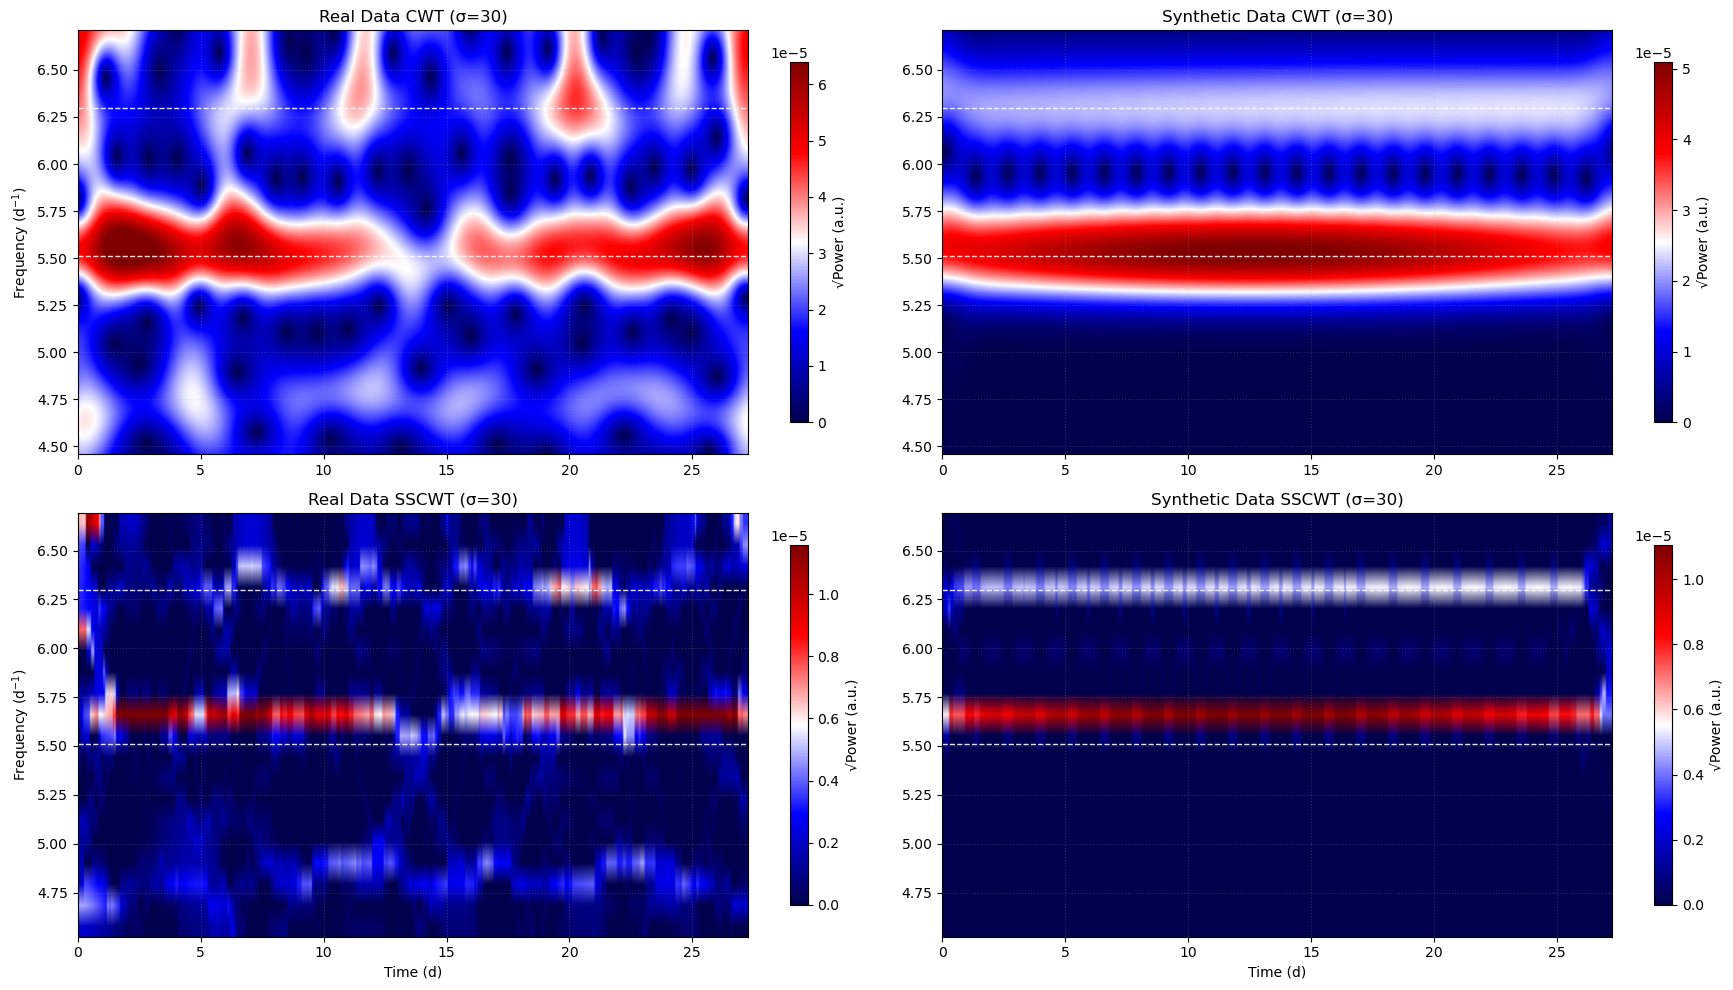


=== Synthetic Analysis Complete ===
Model components: 4
Frequency range: [4.46, 6.71] d^-1


In [12]:
synthetic_results = run_synthetic_data_analysis(
    time, flux,
    frequency_range=(4.46, 6.71),
    forced_frequencies=[5.51, 6.30],
    n_peaks=8,
    prominence_fraction=0.15
)

In [13]:
# ============ Figure 4 Quantitative Analysis Module ============

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

def extract_sscwt_band_energy(freqs, power_2d, center_freq, bandwidth=0.05, 
                             aggregation='sum'):
    """
    Extract frequency band energy time series from SSCWT results
    
    Parameters:
    -----------
    freqs : array_like
        Frequency array (ascending order)
    power_2d : array_like
        2D power array (frequency x time)
    center_freq : float
        Center frequency of the band
    bandwidth : float
        Half-bandwidth around center frequency
    aggregation : str
        Aggregation method ('sum', 'mean', or 'max')
    
    Returns:
    --------
    tuple : (energy_timeseries, frequency_mask)
    """
    freqs = np.asarray(freqs)
    
    # Create frequency band mask
    freq_mask = ((freqs >= (center_freq - bandwidth)) & 
                (freqs <= (center_freq + bandwidth)))
    
    if not np.any(freq_mask):
        raise ValueError(f"No frequency coverage in band "
                        f"{center_freq-bandwidth:.3f}–{center_freq+bandwidth:.3f} d^-1")
    
    # Extract band power
    band_power = power_2d[freq_mask, :]
    
    # Aggregate across frequency
    if aggregation == 'sum':
        energy_timeseries = band_power.sum(axis=0)
    elif aggregation == 'mean':
        energy_timeseries = band_power.mean(axis=0)
    elif aggregation == 'max':
        energy_timeseries = band_power.max(axis=0)
    else:
        raise ValueError("aggregation must be 'sum', 'mean', or 'max'")
    
    return energy_timeseries, freq_mask


def calculate_occupancy_and_dropouts(energy_timeseries, threshold='p80'):
    """
    Calculate energy occupancy and dropout intervals
    
    Parameters:
    -----------
    energy_timeseries : array_like
        Energy time series
    threshold : str or float
        Threshold for occupancy calculation
        - 'p70', 'p80', 'p90': percentile thresholds
        - float 0-1: quantile value
        - float >1: absolute threshold value
    
    Returns:
    --------
    dict : Occupancy and dropout statistics
    """
    energy = np.asarray(energy_timeseries)
    
    # Calculate threshold value
    if isinstance(threshold, str) and threshold.startswith('p'):
        quantile = float(threshold[1:]) / 100.0
        threshold_value = np.quantile(energy, quantile)
    elif isinstance(threshold, (int, float)) and 0 < threshold < 1:
        threshold_value = np.quantile(energy, float(threshold))
    else:
        threshold_value = float(threshold)
    
    # Calculate occupancy
    above_threshold = (energy >= threshold_value)
    below_threshold = ~above_threshold
    
    # Find continuous dropout intervals
    dropout_intervals = []
    if below_threshold.any():
        below_indices = np.where(below_threshold)[0]
        # Find boundaries of continuous segments
        segment_breaks = np.where(np.diff(below_indices) > 1)[0]
        segment_starts = np.r_[below_indices[0], below_indices[segment_breaks + 1]]
        segment_ends = np.r_[below_indices[segment_breaks], below_indices[-1]]
        dropout_intervals = list(zip(segment_starts, segment_ends))
    
    return {
        'threshold': threshold_value,
        'on_fraction': above_threshold.mean(),
        'off_fraction': below_threshold.mean(),
        'dropout_intervals': dropout_intervals,
        'n_dropouts': len(dropout_intervals)
    }


def analyze_ridge_connectivity(power_2d, threshold, min_length=5):
    """
    Analyze ridge connectivity in thresholded SSCWT band image
    
    Parameters:
    -----------
    power_2d : array_like
        2D power array for frequency band
    threshold : float
        Binary threshold for ridge detection
    min_length : int
        Minimum length for connected components
    
    Returns:
    --------
    tuple : (max_component_length, n_components)
    """
    # Create binary image
    binary_image = (power_2d >= threshold).astype(np.uint8)
    
    # Define 4-connectivity structure
    connectivity_structure = np.array([[0, 1, 0],
                                      [1, 1, 1],
                                      [0, 1, 0]], dtype=np.uint8)
    
    # Find connected components
    labeled_image, n_components = label(binary_image, structure=connectivity_structure)
    
    if n_components == 0:
        return 0, 0
    
    # Calculate component sizes (excluding background label 0)
    component_sizes = np.bincount(labeled_image.ravel())[1:]
    significant_sizes = component_sizes[component_sizes >= min_length]
    
    max_length = int(significant_sizes.max()) if significant_sizes.size > 0 else 0
    n_significant_components = int((significant_sizes > 0).sum())
    
    return max_length, n_significant_components


def analyze_figure4_phenomena(time, sscwt_freqs, sscwt_power, 
                             freq_a=5.51, freq_b=6.30, bandwidth=0.05,
                             threshold_a='p80', threshold_b='p80',
                             return_timeseries=False):
    """
    Quantitative analysis of Figure 4 phenomena for two frequency modes
    
    Parameters:
    -----------
    time : array_like
        Time array
    sscwt_freqs : array_like
        SSCWT frequency array
    sscwt_power : array_like
        SSCWT power array (frequency x time)
    freq_a, freq_b : float
        Center frequencies for analysis (default: 5.51, 6.30 d^-1)
    bandwidth : float
        Half-bandwidth for frequency bands
    threshold_a, threshold_b : str or float
        Thresholds for occupancy analysis
    return_timeseries : bool
        Whether to include time series in results
    
    Returns:
    --------
    dict : Comprehensive analysis results
    """
    print(f"Analyzing Figure 4 phenomena for {freq_a:.2f} and {freq_b:.2f} d^-1")
    
    # Extract band energy time series
    energy_a, mask_a = extract_sscwt_band_energy(
        sscwt_freqs, sscwt_power, freq_a, bandwidth=bandwidth, aggregation='sum')
    energy_b, mask_b = extract_sscwt_band_energy(
        sscwt_freqs, sscwt_power, freq_b, bandwidth=bandwidth, aggregation='sum')
    
    # Calculate occupancy and dropouts
    occupancy_a = calculate_occupancy_and_dropouts(energy_a, threshold=threshold_a)
    occupancy_b = calculate_occupancy_and_dropouts(energy_b, threshold=threshold_b)
    
    # Calculate energy correlation (anti-correlation indicates mode competition)
    energy_correlation = np.corrcoef(energy_a, energy_b)[0, 1]
    
    # Analyze ridge connectivity
    connectivity_a = analyze_ridge_connectivity(
        sscwt_power[mask_a, :], threshold=occupancy_a['threshold'], min_length=5)
    connectivity_b = analyze_ridge_connectivity(
        sscwt_power[mask_b, :], threshold=occupancy_b['threshold'], min_length=5)
    
    # Compile results
    analysis_results = {
        'frequencies': {'freq_a': freq_a, 'freq_b': freq_b},
        'parameters': {'bandwidth': bandwidth},
        'energy_correlation': energy_correlation,
        'mode_a': {
            'frequency': freq_a,
            'on_fraction': occupancy_a['on_fraction'],
            'off_fraction': occupancy_a['off_fraction'],
            'threshold': occupancy_a['threshold'],
            'dropout_intervals': occupancy_a['dropout_intervals'],
            'n_dropouts': occupancy_a['n_dropouts'],
            'ridge_max_length': connectivity_a[0],
            'ridge_n_components': connectivity_a[1]
        },
        'mode_b': {
            'frequency': freq_b,
            'on_fraction': occupancy_b['on_fraction'],
            'off_fraction': occupancy_b['off_fraction'],
            'threshold': occupancy_b['threshold'],
            'dropout_intervals': occupancy_b['dropout_intervals'],
            'n_dropouts': occupancy_b['n_dropouts'],
            'ridge_max_length': connectivity_b[0],
            'ridge_n_components': connectivity_b[1]
        }
    }
    
    # Add time series if requested
    if return_timeseries:
        analysis_results['timeseries'] = {
            'time_relative': time - time[0],
            'energy_a': energy_a,
            'energy_b': energy_b
        }
    
    # Print summary
    print(f"Energy correlation: {energy_correlation:.3f} (negative indicates anti-correlation)")
    print(f"Mode A ({freq_a:.2f} d^-1): on_fraction={occupancy_a['on_fraction']:.2f}, "
          f"dropouts={occupancy_a['n_dropouts']}, "
          f"ridge(max,n)=({connectivity_a[0]},{connectivity_a[1]})")
    print(f"Mode B ({freq_b:.2f} d^-1): on_fraction={occupancy_b['on_fraction']:.2f}, "
          f"dropouts={occupancy_b['n_dropouts']}, "
          f"ridge(max,n)=({connectivity_b[0]},{connectivity_b[1]})")
    
    return analysis_results


def plot_band_energy_analysis(analysis_results, title='Band Energy vs Time', 
                              save_figure=True):
    """
    Visualize band energy time series with thresholds and dropout intervals
    
    Parameters:
    -----------
    analysis_results : dict
        Results from analyze_figure4_phenomena()
    title : str
        Plot title
    save_figure : bool
        Whether to save the figure
    """
    if 'timeseries' not in analysis_results:
        print("Error: Time series data not available. Set return_timeseries=True")
        return None
    
    # Extract data
    time_rel = analysis_results['timeseries']['time_relative']
    energy_a = analysis_results['timeseries']['energy_a']
    energy_b = analysis_results['timeseries']['energy_b']
    
    mode_a = analysis_results['mode_a']
    mode_b = analysis_results['mode_b']
    
    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Plot Mode A
    axes[0].plot(time_rel, energy_a, linewidth=1.5, color='blue',
                label=f"{mode_a['frequency']:.2f} d$^{{-1}}$")
    axes[0].axhline(mode_a['threshold'], linestyle='--', color='red', alpha=0.8,
                   label='Threshold')
    
    # Mark dropout intervals
    for start_idx, end_idx in mode_a['dropout_intervals']:
        axes[0].axvspan(time_rel[start_idx], time_rel[end_idx], 
                       color='gray', alpha=0.25)
    
    axes[0].set_ylabel('Band Energy (a.u.)')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, linestyle=':', alpha=0.7)
    
    # Plot Mode B
    axes[1].plot(time_rel, energy_b, linewidth=1.5, color='green',
                label=f"{mode_b['frequency']:.2f} d$^{{-1}}$")
    axes[1].axhline(mode_b['threshold'], linestyle='--', color='red', alpha=0.8,
                   label='Threshold')
    
    # Mark dropout intervals
    for start_idx, end_idx in mode_b['dropout_intervals']:
        axes[1].axvspan(time_rel[start_idx], time_rel[end_idx], 
                       color='gray', alpha=0.25)
    
    axes[1].set_xlabel('Time (d)')
    axes[1].set_ylabel('Band Energy (a.u.)')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, linestyle=':', alpha=0.7)
    
    # Format figure
    fig.suptitle(title, fontsize=14, y=0.98)
    plt.tight_layout()
    
    if save_figure:
        plt.savefig('figures/band_energy_analysis.png', dpi=300, bbox_inches='tight')
        print("Band energy analysis figure saved to figures/band_energy_analysis.png")
    
    plt.show()
    
    return fig


def run_figure4_quantitative_analysis(time, flux, frequency_range=(4.46, 6.71),
                                     target_frequencies=(5.51, 6.30), 
                                     bandwidth=0.05, sigma=30):
    """
    Complete Figure 4 quantitative analysis workflow
    
    Parameters:
    -----------
    time : array_like
        Time array
    flux : array_like
        Flux array
    frequency_range : tuple
        (fmin, fmax) for SSCWT analysis
    target_frequencies : tuple
        (freq_a, freq_b) target frequencies
    bandwidth : float
        Half-bandwidth for frequency bands
    sigma : float
        Morlet wavelet parameter for SSCWT
    
    Returns:
    --------
    dict : Complete quantitative analysis results
    """
    fmin, fmax = frequency_range
    freq_a, freq_b = target_frequencies
    
    print("=== Figure 4 Quantitative Analysis ===")
    print(f"Frequency range: [{fmin:.2f}, {fmax:.2f}] d^-1")
    print(f"Target frequencies: {freq_a:.2f}, {freq_b:.2f} d^-1")
    print(f"Bandwidth: ±{bandwidth} d^-1")
    
    # Calculate SSCWT
    print("Computing SSCWT...")
    sscwt_freqs, _, _, sscwt_power = run_sscwt_analysis(
        time, flux, sigma=sigma, fmin=fmin, fmax=fmax, nv=None, gamma=1e-8)
    
    # Perform quantitative analysis
    analysis_results = analyze_figure4_phenomena(
        time, sscwt_freqs, sscwt_power,
        freq_a=freq_a, freq_b=freq_b, bandwidth=bandwidth,
        threshold_a='p80', threshold_b='p80',
        return_timeseries=True)
    
    # Create visualization
    plot_band_energy_analysis(
        analysis_results, 
        title=f'HD 174966 — SSCWT Band Energy ({fmin:.2f}–{fmax:.2f} d⁻¹)',
        save_figure=True)
    
    print("\n=== Quantitative Analysis Complete ===")
    
    return analysis_results

=== Figure 4 Quantitative Analysis ===
Frequency range: [4.46, 6.71] d^-1
Target frequencies: 5.51, 6.30 d^-1
Bandwidth: ±0.05 d^-1
Computing SSCWT...
Analyzing Figure 4 phenomena for 5.51 and 6.30 d^-1
Energy correlation: -0.165 (negative indicates anti-correlation)
Mode A (5.51 d^-1): on_fraction=0.20, dropouts=10, ridge(max,n)=(5754,9)
Mode B (6.30 d^-1): on_fraction=0.20, dropouts=14, ridge(max,n)=(7475,13)
Band energy analysis figure saved to figures/band_energy_analysis.png


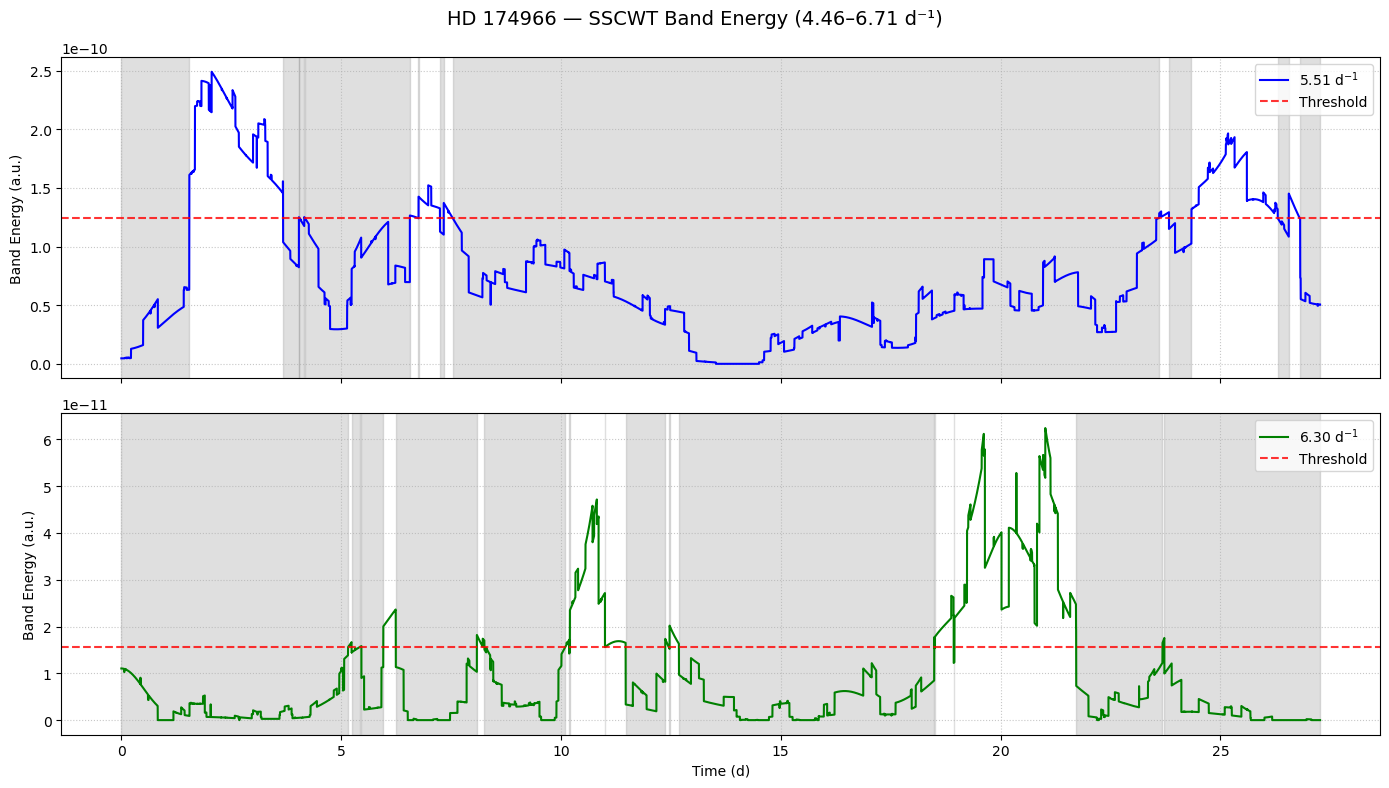


=== Quantitative Analysis Complete ===


In [14]:
fig4_results = run_figure4_quantitative_analysis(
    time, flux,
    frequency_range=(4.46, 6.71),
    target_frequencies=(5.51, 6.30),
    bandwidth=0.05,
    sigma=30
)


In [15]:
# ============ Literature Verification and Total Power Analysis ============

import numpy as np
import matplotlib.pyplot as plt

def pair_literature_detected_frequencies(literature_freqs, detected_freqs, tolerance=0.05):
    """
    Pair literature frequencies with detected frequencies within tolerance
    
    Parameters:
    -----------
    literature_freqs : array_like
        Literature frequency values
    detected_freqs : array_like or None
        Detected frequency values
    tolerance : float
        Pairing tolerance in d^-1
    
    Returns:
    --------
    list : List of pairing dictionaries with keys 'f_lit', 'f_det', 'delta'
    """
    lit_freqs = list(map(float, literature_freqs))
    det_freqs = (np.sort(np.unique(np.round(detected_freqs, 6))) 
                if detected_freqs is not None else np.array([]))
    
    pairs = []
    for freq_lit in lit_freqs:
        if det_freqs.size == 0:
            pairs.append({'f_lit': freq_lit, 'f_det': None, 'delta': None})
            continue
            
        # Find closest detected frequency
        closest_idx = np.argmin(np.abs(det_freqs - freq_lit))
        freq_det = float(det_freqs[closest_idx])
        
        if abs(freq_det - freq_lit) <= tolerance:
            pairs.append({
                'f_lit': freq_lit, 
                'f_det': freq_det, 
                'delta': freq_det - freq_lit
            })
        else:
            pairs.append({'f_lit': freq_lit, 'f_det': None, 'delta': None})
    
    return pairs


def analyze_frequency_pair_energies(time, sscwt_freqs, sscwt_power, 
                                   f_lit, f_det=None, bandwidth=0.05, threshold='p80'):
    """
    Analyze band energies for a literature-detected frequency pair
    
    Parameters:
    -----------
    time : array_like
        Time array
    sscwt_freqs : array_like
        SSCWT frequency array
    sscwt_power : array_like
        SSCWT power array
    f_lit : float
        Literature frequency
    f_det : float or None
        Detected frequency (if paired)
    bandwidth : float
        Half-bandwidth for energy extraction
    threshold : str or float
        Threshold for occupancy analysis
    
    Returns:
    --------
    dict : Analysis results for the frequency pair
    """
    results = {'f_lit': f_lit, 'f_det': f_det}
    
    # Analyze literature frequency
    energy_lit, _ = extract_sscwt_band_energy(
        sscwt_freqs, sscwt_power, f_lit, bandwidth=bandwidth, aggregation='sum')
    occupancy_lit = calculate_occupancy_and_dropouts(energy_lit, threshold=threshold)
    
    results.update({
        'energy_lit': energy_lit,
        'threshold_lit': occupancy_lit['threshold'],
        'on_fraction_lit': occupancy_lit['on_fraction'],
        'dropout_segments_lit': occupancy_lit['n_dropouts']
    })
    
    # Analyze detected frequency if available
    if f_det is not None:
        energy_det, _ = extract_sscwt_band_energy(
            sscwt_freqs, sscwt_power, f_det, bandwidth=bandwidth, aggregation='sum')
        occupancy_det = calculate_occupancy_and_dropouts(energy_det, threshold=threshold)
        correlation = float(np.corrcoef(energy_lit, energy_det)[0, 1])
        
        results.update({
            'energy_det': energy_det,
            'threshold_det': occupancy_det['threshold'],
            'on_fraction_det': occupancy_det['on_fraction'],
            'dropout_segments_det': occupancy_det['n_dropouts'],
            'correlation_lit_det': correlation
        })
    else:
        results.update({
            'energy_det': None,
            'threshold_det': None,
            'on_fraction_det': None,
            'dropout_segments_det': None,
            'correlation_lit_det': None
        })
    
    return results


def verify_literature_vs_detected(time, flux, literature_freqs=(5.51, 6.30),
                                 detected_freqs=None, search_band=(4.46, 6.71),
                                 sigma=30, nv=None, gamma=1e-8,
                                 pairing_tolerance=0.05, bandwidth=0.05, 
                                 threshold='p80', create_plot=True, save_figure=True):
    """
    Complete literature vs detected frequency verification workflow
    
    Parameters:
    -----------
    time : array_like
        Time array
    flux : array_like
        Flux array
    literature_freqs : tuple
        Literature frequency values
    detected_freqs : array_like or None
        Detected frequencies (if None, auto-detect)
    search_band : tuple
        (fmin, fmax) frequency range for SSCWT
    sigma : float
        Morlet wavelet parameter
    pairing_tolerance : float
        Tolerance for frequency pairing
    bandwidth : float
        Half-bandwidth for energy extraction
    threshold : str or float
        Threshold for occupancy analysis
    create_plot : bool
        Whether to create visualization
    save_figure : bool
        Whether to save the figure
    
    Returns:
    --------
    dict : Complete verification results
    """
    fmin, fmax = search_band
    
    print("=== Literature vs Detected Frequency Verification ===")
    print(f"Literature frequencies: {literature_freqs}")
    print(f"Search band: [{fmin:.2f}, {fmax:.2f}] d^-1")
    
    # Auto-detect frequencies if not provided
    if detected_freqs is None:
        detected_freqs = find_frequency_peaks_fft(
            time, flux, fmin=fmin, fmax=fmax, n_peaks=12, prominence_fraction=0.12)
        print(f"Auto-detected frequencies: {detected_freqs}")
    else:
        print(f"Provided detected frequencies: {detected_freqs}")
    
    # Calculate SSCWT
    print("Computing SSCWT for verification...")
    sscwt_freqs, _, _, sscwt_power = run_sscwt_analysis(
        time, flux, sigma=sigma, fmin=fmin, fmax=fmax, nv=nv, gamma=gamma)
    
    time_rel = time - time[0]
    
    # Pair frequencies
    frequency_pairs = pair_literature_detected_frequencies(
        literature_freqs, detected_freqs, tolerance=pairing_tolerance)
    
    print(f"\nFrequency pairing (tolerance ±{pairing_tolerance} d^-1):")
    for pair in frequency_pairs:
        if pair['f_det'] is not None:
            print(f"  {pair['f_lit']:.2f} → {pair['f_det']:.3f} d^-1 (Δ = {pair['delta']:+.3f})")
        else:
            print(f"  {pair['f_lit']:.2f} → No match found")
    
    # Analyze each frequency pair
    verification_results = []
    for pair in frequency_pairs:
        analysis_result = analyze_frequency_pair_energies(
            time, sscwt_freqs, sscwt_power,
            f_lit=pair['f_lit'], f_det=pair['f_det'],
            bandwidth=bandwidth, threshold=threshold)
        
        # Merge pairing info with analysis results
        analysis_result.update(pair)
        verification_results.append(analysis_result)
    
    # Create visualization
    if create_plot:
        n_pairs = len(verification_results)
        ncols = 2 if n_pairs > 1 else 1
        nrows = int(np.ceil(n_pairs / ncols))
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.5*nrows), sharex=True)
        axes = np.atleast_1d(axes).ravel()
        
        for i, (ax, result) in enumerate(zip(axes, verification_results)):
            # Plot literature frequency energy (normalized)
            energy_lit = result['energy_lit']
            energy_lit_norm = energy_lit / (np.max(energy_lit) + 1e-12)
            ax.plot(time_rel, energy_lit_norm, linewidth=1.4, 
                   label=f"Literature {result['f_lit']:.2f} d⁻¹")
            
            # Plot literature threshold
            threshold_lit_norm = result['threshold_lit'] / (np.max(energy_lit) + 1e-12)
            ax.axhline(threshold_lit_norm, linestyle='--', color='red', alpha=0.7, linewidth=1)
            
            # Plot detected frequency energy if available
            correlation_text = ""
            if result['energy_det'] is not None:
                energy_det = result['energy_det']
                energy_det_norm = energy_det / (np.max(energy_det) + 1e-12)
                ax.plot(time_rel, energy_det_norm, linewidth=1.2, 
                       label=f"Detected {result['f_det']:.3f} d⁻¹")
                
                # Plot detected threshold
                if result['threshold_det'] is not None:
                    threshold_det_norm = result['threshold_det'] / (np.max(energy_det) + 1e-12)
                    ax.axhline(threshold_det_norm, linestyle=':', color='orange', alpha=0.7, linewidth=1)
                
                if result['correlation_lit_det'] is not None:
                    correlation_text = f", r={result['correlation_lit_det']:.2f}"
            
            # Format subplot
            ax.set_ylim(0, 1.15)
            ax.set_ylabel("Normalized Band Energy")
            
            # Create title with statistics
            title_parts = [f"{result['f_lit']:.2f}"]
            if result['f_det'] is not None:
                title_parts.append(f"(~{result['f_det']:.3f})")
            title_parts.append(f"d⁻¹ — on={result['on_fraction_lit']:.2f}")
            
            if result['on_fraction_det'] is not None:
                title_parts.append(f"/{result['on_fraction_det']:.2f}")
            
            title_parts.append(f", drops={result['dropout_segments_lit']}")
            if result['dropout_segments_det'] is not None:
                title_parts.append(f"/{result['dropout_segments_det']}")
            
            title_parts.append(correlation_text)
            
            ax.set_title("".join(title_parts))
            ax.grid(True, linestyle=':', alpha=0.7)
            ax.legend(loc='upper right')
        
        # Hide unused subplots
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        
        # Set x-label for bottom row
        for ax in axes[-ncols:]:
            ax.set_xlabel("Time (d)")
        
        plt.tight_layout()
        plt.suptitle("Literature vs Detected — Band Energy Consistency", 
                    y=1.02, fontsize=14)
        
        if save_figure:
            plt.savefig('figures/literature_vs_detected_verification.png', 
                       dpi=300, bbox_inches='tight')
            print("Literature verification figure saved to figures/literature_vs_detected_verification.png")
        
        plt.show()
    
    # Compile complete results
    complete_results = {
        'frequency_pairs': verification_results,
        'sscwt_freqs': sscwt_freqs,
        'sscwt_power': sscwt_power,
        'time_relative': time_rel,
        'parameters': {
            'literature_freqs': literature_freqs,
            'detected_freqs': detected_freqs,
            'search_band': search_band,
            'pairing_tolerance': pairing_tolerance,
            'bandwidth': bandwidth,
            'threshold': threshold
        }
    }
    
    return complete_results


def analyze_total_power_constancy(verification_results, prefer_detected=True):
    """
    Analyze total power constancy across frequency modes
    
    Parameters:
    -----------
    verification_results : dict
        Results from verify_literature_vs_detected()
    prefer_detected : bool
        Whether to prefer detected frequencies over literature
    
    Returns:
    --------
    dict : Total power analysis results
    """
    print("\n=== Total Power Constancy Analysis ===")
    
    frequency_pairs = verification_results['frequency_pairs']
    
    if len(frequency_pairs) < 2:
        print("Error: Need at least 2 frequency pairs for total power analysis")
        return None
    
    def select_energy_series(pair, prefer='det'):
        """Select energy series preferring detected over literature"""
        if prefer == 'det' and pair.get('energy_det') is not None:
            return pair['energy_det'], f"detected {pair['f_det']:.3f} d⁻¹"
        return pair['energy_lit'], f"literature {pair['f_lit']:.2f} d⁻¹"
    
    # Extract energy series for the two main modes
    energy_1, label_1 = select_energy_series(frequency_pairs[0], 
                                           prefer='det' if prefer_detected else 'lit')
    energy_2, label_2 = select_energy_series(frequency_pairs[1], 
                                           prefer='det' if prefer_detected else 'lit')
    
    # Safety checks
    if energy_1 is None or energy_2 is None:
        print("Error: One of the energy series is None")
        return None
    
    if len(energy_1) != len(energy_2):
        print("Error: Length mismatch between energy series")
        return None
    
    # Calculate total power and statistics
    total_power = energy_1 + energy_2
    mean_total = float(np.mean(total_power))
    std_total = float(np.std(total_power))
    cv_total = float(std_total / mean_total * 100)  # Coefficient of variation in %
    
    # Calculate individual coefficients of variation for comparison
    cv_1 = float(np.std(energy_1) / np.mean(energy_1) * 100)
    cv_2 = float(np.std(energy_2) / np.mean(energy_2) * 100)
    
    # Print results
    print(f"Using energy series:")
    print(f"  Mode 1: {label_1}")
    print(f"  Mode 2: {label_2}")
    print(f"\nTotal power statistics:")
    print(f"  Mean: {mean_total:.6g}")
    print(f"  Standard deviation: {std_total:.6g}")
    print(f"  Coefficient of variation: {cv_total:.3f}%")
    print(f"\nIndividual mode variations:")
    print(f"  Mode 1 CV: {cv_1:.2f}%")
    print(f"  Mode 2 CV: {cv_2:.2f}%")
    print(f"\nTotal power is {'more' if cv_total < min(cv_1, cv_2) else 'less'} stable than individual modes")
    
    # Compile results
    total_power_results = {
        'energy_1': energy_1,
        'energy_2': energy_2,
        'total_power': total_power,
        'mean_total': mean_total,
        'std_total': std_total,
        'cv_total': cv_total,
        'cv_mode_1': cv_1,
        'cv_mode_2': cv_2,
        'labels': {'mode_1': label_1, 'mode_2': label_2},
        'prefer_detected': prefer_detected
    }
    
    return total_power_results


def run_literature_verification_analysis(time, flux, literature_freqs=(5.51, 6.30),
                                        detected_freqs=None, 
                                        search_band=(4.46, 6.71)):
    """
    Complete literature verification and total power analysis workflow
    
    Parameters:
    -----------
    time : array_like
        Time array
    flux : array_like
        Flux array
    literature_freqs : tuple
        Literature frequency values
    detected_freqs : array_like or None
        Detected frequencies (if None, will use example values)
    search_band : tuple
        Frequency range for analysis
    
    Returns:
    --------
    dict : Complete analysis results
    """
    # Use example detected frequencies if not provided
    if detected_freqs is None:
        detected_freqs = np.array([5.53768, 6.307821])  # Example values
        print(f"Using example detected frequencies: {detected_freqs}")
    
    # Run verification analysis
    verification_results = verify_literature_vs_detected(
        time, flux,
        literature_freqs=literature_freqs,
        detected_freqs=detected_freqs,
        search_band=search_band,
        sigma=30, nv=None, gamma=1e-8,
        pairing_tolerance=0.05,
        bandwidth=0.05,
        threshold='p80',
        create_plot=True,
        save_figure=True
    )
    
    # Print verification summary
    print("\n=== Verification Summary ===")
    for pair in verification_results['frequency_pairs']:
        summary_parts = [f"{pair['f_lit']:.2f}"]
        if pair['f_det'] is not None:
            summary_parts.append(f" (~{pair['f_det']:.3f})")
        summary_parts.append(f" d⁻¹: on(lit)={pair['on_fraction_lit']:.2f}")
        
        if pair['on_fraction_det'] is not None:
            summary_parts.append(f", on(det)={pair['on_fraction_det']:.2f}")
        
        summary_parts.append(f"; drops(lit)={pair['dropout_segments_lit']}")
        if pair['dropout_segments_det'] is not None:
            summary_parts.append(f", drops(det)={pair['dropout_segments_det']}")
        
        if pair['correlation_lit_det'] is not None:
            summary_parts.append(f"; corr(lit,det)={pair['correlation_lit_det']:.2f}")
        
        print("".join(summary_parts))
    
    # Analyze total power constancy
    total_power_results = analyze_total_power_constancy(
        verification_results, prefer_detected=True)
    
    # Compile complete results
    complete_results = {
        'verification_results': verification_results,
        'total_power_results': total_power_results
    }
    
    print("\n=== Literature Verification Analysis Complete ===")
    
    return complete_results

=== Literature vs Detected Frequency Verification ===
Literature frequencies: [5.51, 6.3]
Search band: [4.46, 6.71] d^-1
Provided detected frequencies: [5.53768  6.307821]
Computing SSCWT for verification...

Frequency pairing (tolerance ±0.05 d^-1):
  5.51 → 5.538 d^-1 (Δ = +0.028)
  6.30 → 6.308 d^-1 (Δ = +0.008)
Literature verification figure saved to figures/literature_vs_detected_verification.png


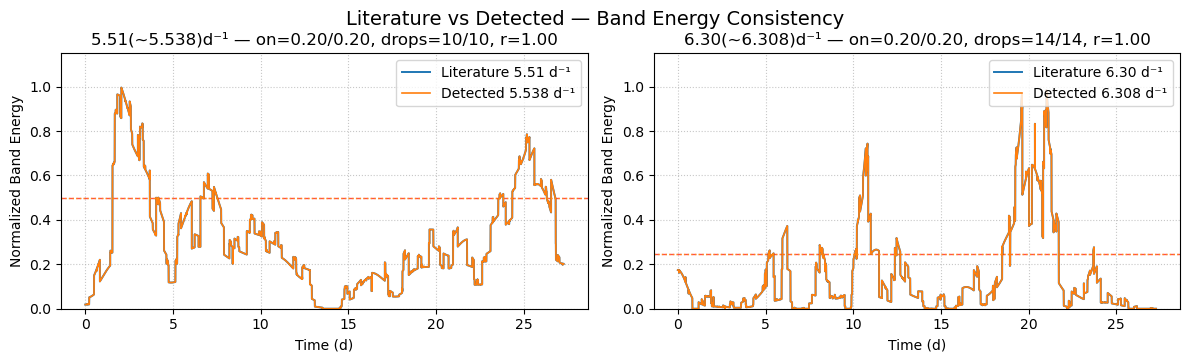


=== Verification Summary ===
5.51 (~5.538) d⁻¹: on(lit)=0.20, on(det)=0.20; drops(lit)=10, drops(det)=10; corr(lit,det)=1.00
6.30 (~6.308) d⁻¹: on(lit)=0.20, on(det)=0.20; drops(lit)=14, drops(det)=14; corr(lit,det)=1.00

=== Total Power Constancy Analysis ===
Using energy series:
  Mode 1: detected 5.538 d⁻¹
  Mode 2: detected 6.308 d⁻¹

Total power statistics:
  Mean: 8.6794e-11
  Standard deviation: 5.49986e-11
  Coefficient of variation: 63.367%

Individual mode variations:
  Mode 1 CV: 71.56%
  Mode 2 CV: 137.25%

Total power is more stable than individual modes

=== Literature Verification Analysis Complete ===


In [16]:
literature_freqs = [5.51, 6.30]
detected_freqs = np.array([5.53768, 6.307821])

complete_results = run_literature_verification_analysis(
    time, flux,
    literature_freqs=literature_freqs,
    detected_freqs=detected_freqs,
    search_band=(4.46, 6.71)
)